In [13]:
"""
We are working on reproducing the experiment Na2-Marc, provided in examples.

To do so, we run the experiment with a combination of all possible compilation option
DebugMode or not, gfortran or ifort, OMP or not, DYN OMP or not, MKL or FFTW.

We want to check for numerical reproducibility, performance, and energy consumption.
"""

'\nWe are working on reproducing the experiment Na2-Marc, provided in examples.\n\nTo do so, we run the experiment with a combination of all possible compilation option\nDebugMode or not, gfortran or ifort, OMP or not, DYN OMP or not, MKL or FFTW.\n\nWe want to check for numerical reproducibility, performance, and energy consumption.\n'

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import re

def extract_from_result(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()[-10:]
        real_time_match = re.findall(r"real\s+(\d+)m(\d+),\d+s", ''.join(lines))
        user_time_match = re.findall(r"user\s+(\d+)m(\d+),\d+s", ''.join(lines))
        
        if not real_time_match or not user_time_match:
            return None, None
##Get rid of milliseconds from time command
        real_time = 60 * float(real_time_match[0][0]) + float(real_time_match[0][1])
        user_time = 60 * float(user_time_match[0][0]) + float(user_time_match[0][1])
    return real_time, user_time


def extract_from_consumption(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            match = re.search(r"Total energy:\s+([\d\.]+)\s+Joules", line)
            if match:
                consumption = float(match.group(1))
                return consumption
    print(f"Warning: Unable to extract energy value from {filepath}.")
    return None


def file_differs(file1, file2):
    with open(file1, 'rb') as f1, open(file2, 'rb') as f2:
        return f1.read() != f2.read()


def extract_values(folder_path):
    print(f"\t\tExtracting time data from {folder_path}/time.txt")
    real_time, user_time = extract_from_result(os.path.join(folder_path, "time.txt"))
    
    print(f"\t\tExtracting energy consumption from {folder_path}/consumption.txt")
    consumption = extract_from_consumption(os.path.join(folder_path, "consumption.txt"))

    return real_time, user_time, consumption

def display_and_save_table(df, filename, title=""):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.axis('off')
    ax.set_title(title, fontsize=16)
    tab = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tab.auto_set_font_size(False)
    tab.set_fontsize(10)
    tab.scale(1.5, 1.5)

    # Adjust the width of the first column
    col_width = {idx: 0.2 for idx in range(len(df.columns))}
    col_width[0] = 0.4  # Set width of the first column to 0.4 (increase or decrease as needed)
    for idx, width in col_width.items():
        tab.auto_set_column_width(idx)

    for (i, j), cell in tab.get_celld().items():
        if i == 0:
            cell.set_text_props(fontweight='bold')
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

def reshaped_dataframe(df):
    df['Experiment'] = df['Name'].apply(lambda x: x.rsplit('-', 1)[0])
    grouped_df = df.groupby('Experiment')
    merged_rows = []

    for name, group in grouped_df:
        if group.shape[0] == 50:  # Check for 50 replications
            data = {'Experiment': name}
            
            for rep in range(1, 51):
                row = group[group['Name'].str.endswith(f'repli{rep}')].iloc[0]
                
                # Paths for the files in each replication
                #for file in comparison_files:
                 #   file_path_1 = os.path.join(base_path, name, f"repli{rep}", file)
                  #  file_path_2 = os.path.join(example_path, file)
                   # file_diff = file_differs(file_path_1, file_path_2)
                    #data[f"{file} {rep} vs example Diff"] = 'Different' if file_diff else 'Same'
                
                data[f'Real time {rep} (s)'] = row['Real time (s)']
                data[f'User time {rep} (s)'] = row['User time (s)']
                data[f'Consumption {rep} (J)'] = row['Consumption (J)']

            merged_rows.append(data)
    merged_df = pd.DataFrame(merged_rows)
    return merged_df


base_path = '.'  # current directory
#comparison_files = ["penergies.Na2-egs","pdip.Na2-egs","pescel.Na2-egs"]

df = pd.DataFrame(columns=["Name", "Real time (s)", "User time (s)", "Consumption (J)"])

folders = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]

print("Starting data extraction...")
total_folders = len(folders)
for idx, folder in enumerate(folders, 1):
    print(f"Processing folder {idx}/{total_folders}: {folder}")
    
    for rep in range(1, 51):  # This will loop from 1 to 50 inclusive.
        sub_folder = f"repli{rep}"

        full_path = os.path.join(base_path, folder, sub_folder)
        
        if os.path.exists(full_path):
            print(f"\tExtracting from: {sub_folder}")
            real_time, user_time, consumption = extract_values(full_path)
            row = {
                "Name": f"{folder}-{sub_folder}",
                "Real time (s)": real_time,
                "User time (s)": user_time,
                "Consumption (J)": consumption
            }
            df.loc[len(df)] = row
print("Data extraction completed!")


# Convert seconds to minutes
df['Real time (min)'] = df['Real time (s)'] / 60
df['User time (min)'] = df['User time (s)'] / 60

# Calculate energy consumption for Real time and User time
df['Consumption (Real time) (J)'] = df['Real time (min)'] * df['Consumption (J)']
df['Consumption (User time) (J)'] = df['User time (min)'] * df['Consumption (J)']

# Drop the helper columns (Real time (min) and User time (min))
df = df.drop(columns=['Real time (min)', 'User time (min)'])

# Format the dataframe and display
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].apply(lambda x: '{:.2f}'.format(x))

df["Real time (s)"] = df["Real time (s)"].astype(float)
df["User time (s)"] = df["User time (s)"].astype(float)
df["Consumption (J)"] = df["Consumption (J)"].astype(float)
df["Consumption (Real time) (J)"] = df["Consumption (Real time) (J)"].astype(float)
df["Consumption (User time) (J)"] = df["Consumption (User time) (J)"].astype(float)




# Reshape the dataframe
reshaped_df = reshaped_dataframe(df)

# Real time calculations
cols_real_time = [f'Real time {i} (s)' for i in range(1, 51)]
reshaped_df['Mean Real time (s)'] = reshaped_df[cols_real_time].mean(axis=1)
# Similarly, you can compute the variability, but you might want to choose a different approach for 10 values.

# User time calculations
cols_user_time = [f'User time {i} (s)' for i in range(1, 51)]
reshaped_df['Mean User time (s)'] = reshaped_df[cols_user_time].mean(axis=1)
# Again, compute the variability for user time as per your requirements.

# Energy consumption
cols_consumption = [f'Consumption {i} (J)' for i in range(1, 51)]
reshaped_df['Mean Consumption (J)'] = reshaped_df[cols_consumption].mean(axis=1)
# Compute variability for consumption.


reshaped_df['Consumption (Mean Real) (J)'] = ((reshaped_df['Mean Real time (s)']/60) * (reshaped_df['Mean Consumption (J)']))
reshaped_df['Consumption (Mean User) (J)'] = ((reshaped_df['Mean User time (s)']/60) * (reshaped_df['Mean Consumption (J)']))


 
# Formatting:
cols_to_format = reshaped_df.select_dtypes(include=['float64']).columns
for col in cols_to_format:
    reshaped_df[col] = reshaped_df[col].round(2)

    
    
# Current column ordering
cols = reshaped_df.columns.tolist()
# Real time variability
reshaped_df['Std Real time (s)'] = reshaped_df[cols_real_time].std(axis=1).round(2)

# User time variability
reshaped_df['Std User time (s)'] = reshaped_df[cols_user_time].std(axis=1).round(2)

# Consumption variability
reshaped_df['Std Consumption (J)'] = reshaped_df[cols_consumption].std(axis=1).round(2)

desired_order = [
    'Experiment',
]

# Add entries for real time, user time, and consumption for each replication
for i in range(1, 51):
    desired_order.extend([
        f'Real time {i} (s)',
        f'User time {i} (s)',
        f'Consumption {i} (J)',
        f'Consumption (Real time) {i} (J)',
        f'Consumption (User time) {i} (J)',
    ])

# Mean and variability entries
desired_order.extend([
    'Mean Real time (s)',
    'Std Real time (s)',
    'Mean User time (s)',
    'Std User time (s)',
    'Std Consumption (J)',
    'Consumption (Mean Real) (J)',
    'Consumption (Mean User) (J)'
])

      
print(desired_order)


desired_cols_present = [col for col in desired_order if col in reshaped_df.columns]
if len(desired_cols_present) < len(desired_order):
    print("Warning: Some columns in 'desired_order' are missing in 'reshaped_df'.")
reshaped_df = reshaped_df[desired_cols_present]


print(reshaped_df.columns)

missing_columns = set(desired_order) - set(reshaped_df.columns)
print(missing_columns)

"""
# Displaying ordered tables:
for order_col in ["Consumption (Mean Real) (J)", "Consumption (Mean User) (J)", "Mean Real time (s)", "Mean User time (s)"]:
    if order_col in reshaped_df.columns:
        ordered_reshaped_df = reshaped_df.sort_values(by=order_col, ascending=True)
        title = f"Table Ordered by {order_col}"
        display_and_save_table(ordered_reshaped_df, f'table_reshaped_sorted_by_{order_col}.png', title)
    else:
        print(f"Warning: {order_col} not found in reshaped_df.")
"""


Starting data extraction...
Processing folder 1/38: qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug
	Extracting from: repli1
		Extracting time data from ./qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug/repli1/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug/repli1/consumption.txt
	Extracting from: repli2
		Extracting time data from ./qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug/repli2/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug/repli2/consumption.txt
	Extracting from: repli3
		Extracting time data from ./qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug/repli3/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug/repli3/consumption.txt
	Extracting from: repli4
		Extracting time data from ./qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug/repli4/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug/repli4/consumption.txt
	E

		Extracting energy consumption from ./qdd-ifx-linux-FFTW-OMP-DYN-noStatic-noDebug/repli48/consumption.txt
	Extracting from: repli49
		Extracting time data from ./qdd-ifx-linux-FFTW-OMP-DYN-noStatic-noDebug/repli49/time.txt
		Extracting energy consumption from ./qdd-ifx-linux-FFTW-OMP-DYN-noStatic-noDebug/repli49/consumption.txt
	Extracting from: repli50
		Extracting time data from ./qdd-ifx-linux-FFTW-OMP-DYN-noStatic-noDebug/repli50/time.txt
		Extracting energy consumption from ./qdd-ifx-linux-FFTW-OMP-DYN-noStatic-noDebug/repli50/consumption.txt
Processing folder 7/38: qdd-ifx-linux-FFTW-OMP-noStatic-Debug
	Extracting from: repli1
		Extracting time data from ./qdd-ifx-linux-FFTW-OMP-noStatic-Debug/repli1/time.txt
		Extracting energy consumption from ./qdd-ifx-linux-FFTW-OMP-noStatic-Debug/repli1/consumption.txt
	Extracting from: repli2
		Extracting time data from ./qdd-ifx-linux-FFTW-OMP-noStatic-Debug/repli2/time.txt
		Extracting energy consumption from ./qdd-ifx-linux-FFTW-OMP-noS

		Extracting energy consumption from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli8/consumption.txt
	Extracting from: repli9
		Extracting time data from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli9/time.txt
		Extracting energy consumption from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli9/consumption.txt
	Extracting from: repli10
		Extracting time data from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli10/time.txt
		Extracting energy consumption from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli10/consumption.txt
	Extracting from: repli11
		Extracting time data from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli11/time.txt
		Extracting energy consumption from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli11/consumption.txt
	Extracting from: repli12
		Extracting time data from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli12/time.txt
		Extracting energy consumption from ./qdd-ifx-linux-MKL-OMP-noStatic-noDebug/repli12/consumption.txt
	Extracting from: repli13
		Extracting time da

		Extracting energy consumption from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/repli17/consumption.txt
	Extracting from: repli18
		Extracting time data from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/repli18/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/repli18/consumption.txt
	Extracting from: repli19
		Extracting time data from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/repli19/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/repli19/consumption.txt
	Extracting from: repli20
		Extracting time data from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/repli20/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/repli20/consumption.txt
	Extracting from: repli21
		Extracting time data from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/repli21/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug/rep

		Extracting energy consumption from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli22/consumption.txt
	Extracting from: repli23
		Extracting time data from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli23/time.txt
		Extracting energy consumption from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli23/consumption.txt
	Extracting from: repli24
		Extracting time data from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli24/time.txt
		Extracting energy consumption from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli24/consumption.txt
	Extracting from: repli25
		Extracting time data from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli25/time.txt
		Extracting energy consumption from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli25/consumption.txt
	Extracting from: repli26
		Extracting time data from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli26/time.txt
		Extracting energy consumption from ./qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug/repli26/consumption.txt
	Extra

		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli27/consumption.txt
	Extracting from: repli28
		Extracting time data from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli28/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli28/consumption.txt
	Extracting from: repli29
		Extracting time data from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli29/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli29/consumption.txt
	Extracting from: repli30
		Extracting time data from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli30/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli30/consumption.txt
	Extracting from: repli31
		Extracting time data from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli31/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-MKL-noOMP-noStatic-Debug/repli31/consumption.t

		Extracting energy consumption from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli31/consumption.txt
	Extracting from: repli32
		Extracting time data from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli32/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli32/consumption.txt
	Extracting from: repli33
		Extracting time data from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli33/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli33/consumption.txt
	Extracting from: repli34
		Extracting time data from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli34/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli34/consumption.txt
	Extracting from: repli35
		Extracting time data from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli35/time.txt
		Extracting energy consumption from ./qdd-gfortran-linux-FFTW-OMP-noStatic-Debug/repli35/consumption.txt
	Extra

		Extracting energy consumption from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli34/consumption.txt
	Extracting from: repli35
		Extracting time data from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli35/time.txt
		Extracting energy consumption from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli35/consumption.txt
	Extracting from: repli36
		Extracting time data from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli36/time.txt
		Extracting energy consumption from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli36/consumption.txt
	Extracting from: repli37
		Extracting time data from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli37/time.txt
		Extracting energy consumption from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli37/consumption.txt
	Extracting from: repli38
		Extracting time data from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli38/time.txt
		Extracting energy consumption from ./qdd-ifort-linux-FFTW-noOMP-noStatic-Debug/repli38/consumption.txt
	Extracting fro

'\n# Displaying ordered tables:\nfor order_col in ["Consumption (Mean Real) (J)", "Consumption (Mean User) (J)", "Mean Real time (s)", "Mean User time (s)"]:\n    if order_col in reshaped_df.columns:\n        ordered_reshaped_df = reshaped_df.sort_values(by=order_col, ascending=True)\n        title = f"Table Ordered by {order_col}"\n        display_and_save_table(ordered_reshaped_df, f\'table_reshaped_sorted_by_{order_col}.png\', title)\n    else:\n        print(f"Warning: {order_col} not found in reshaped_df.")\n'

Index(['Name'], dtype='object')
['qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug', 'qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug', 'qdd-gfortran-linux-FFTW-OMP-noStatic-Debug', 'qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug', 'qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug', 'qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug', 'qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug', 'qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug', 'qdd-gfortran-linux-MKL-OMP-noStatic-Debug', 'qdd-gfortran-linux-MKL-OMP-noStatic-noDebug', 'qdd-gfortran-linux-MKL-noOMP-noStatic-Debug', 'qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug', 'qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debug', 'qdd-ifort-linux-FFTW-OMP-DYN-noStatic-noDebug', 'qdd-ifort-linux-FFTW-OMP-noStatic-Debug', 'qdd-ifort-linux-FFTW-OMP-noStatic-noDebug', 'qdd-ifort-linux-FFTW-noOMP-noStatic-Debug', 'qdd-ifort-linux-FFTW-noOMP-noStatic-noDebug', 'qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug', 'qdd-ifort-linux-MKL-OMP-DYN-noStatic-noDebug', 'qdd-ifort-linu

Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
All replication files for experiment 'qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug' with filename 'penergies.Na2-egs' are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Fil

Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
All replication files for experiment 'qdd-ifort-linux-FFTW-OMP-noStatic-noDebug' with filename 'penergies.Na2-egs' are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are

Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
All replication files for experiment 'qdd-ifort-linux-MKL-noOMP-noStatic-noDebug' with filename 'penergies.Na2-egs' are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files ar

Files are identical.
All replication files for experiment 'qdd-ifx-linux-MKL-OMP-DYN-noStatic-noDebug' with filename 'penergies.Na2-egs' are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files are identical.
Files ar

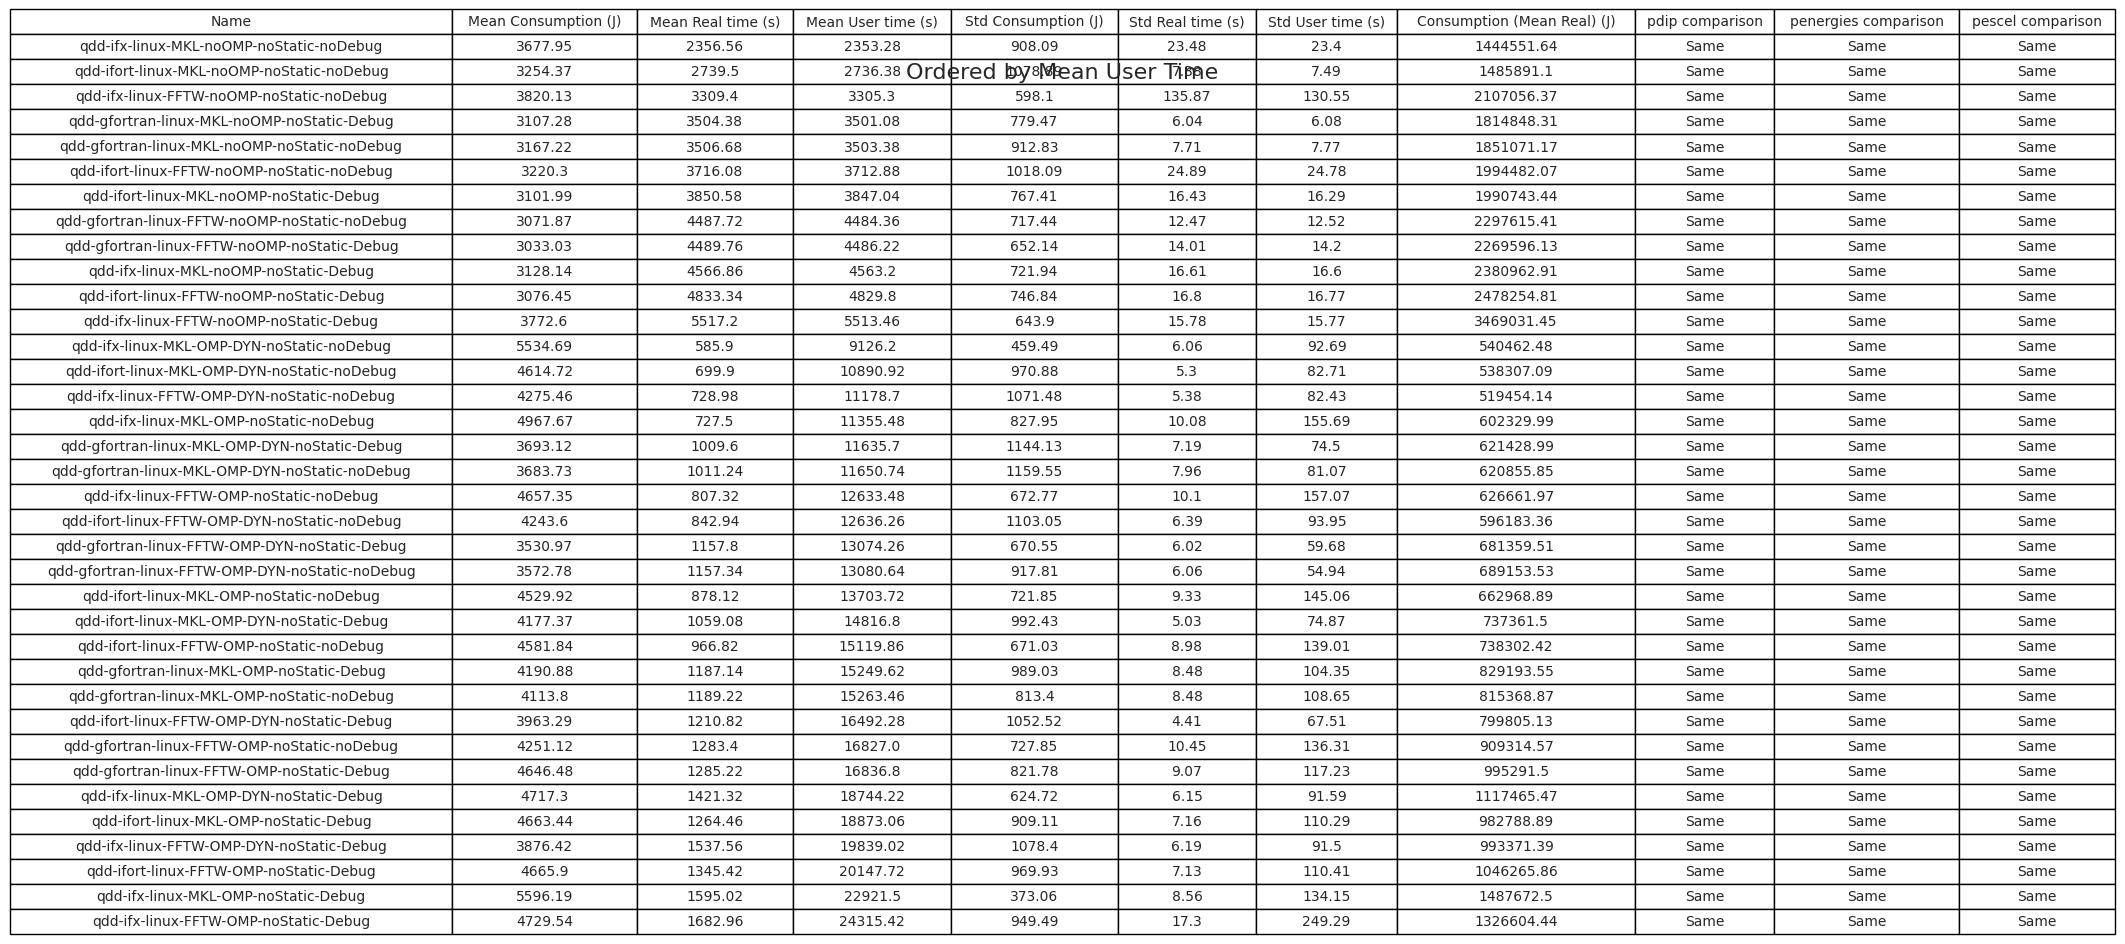

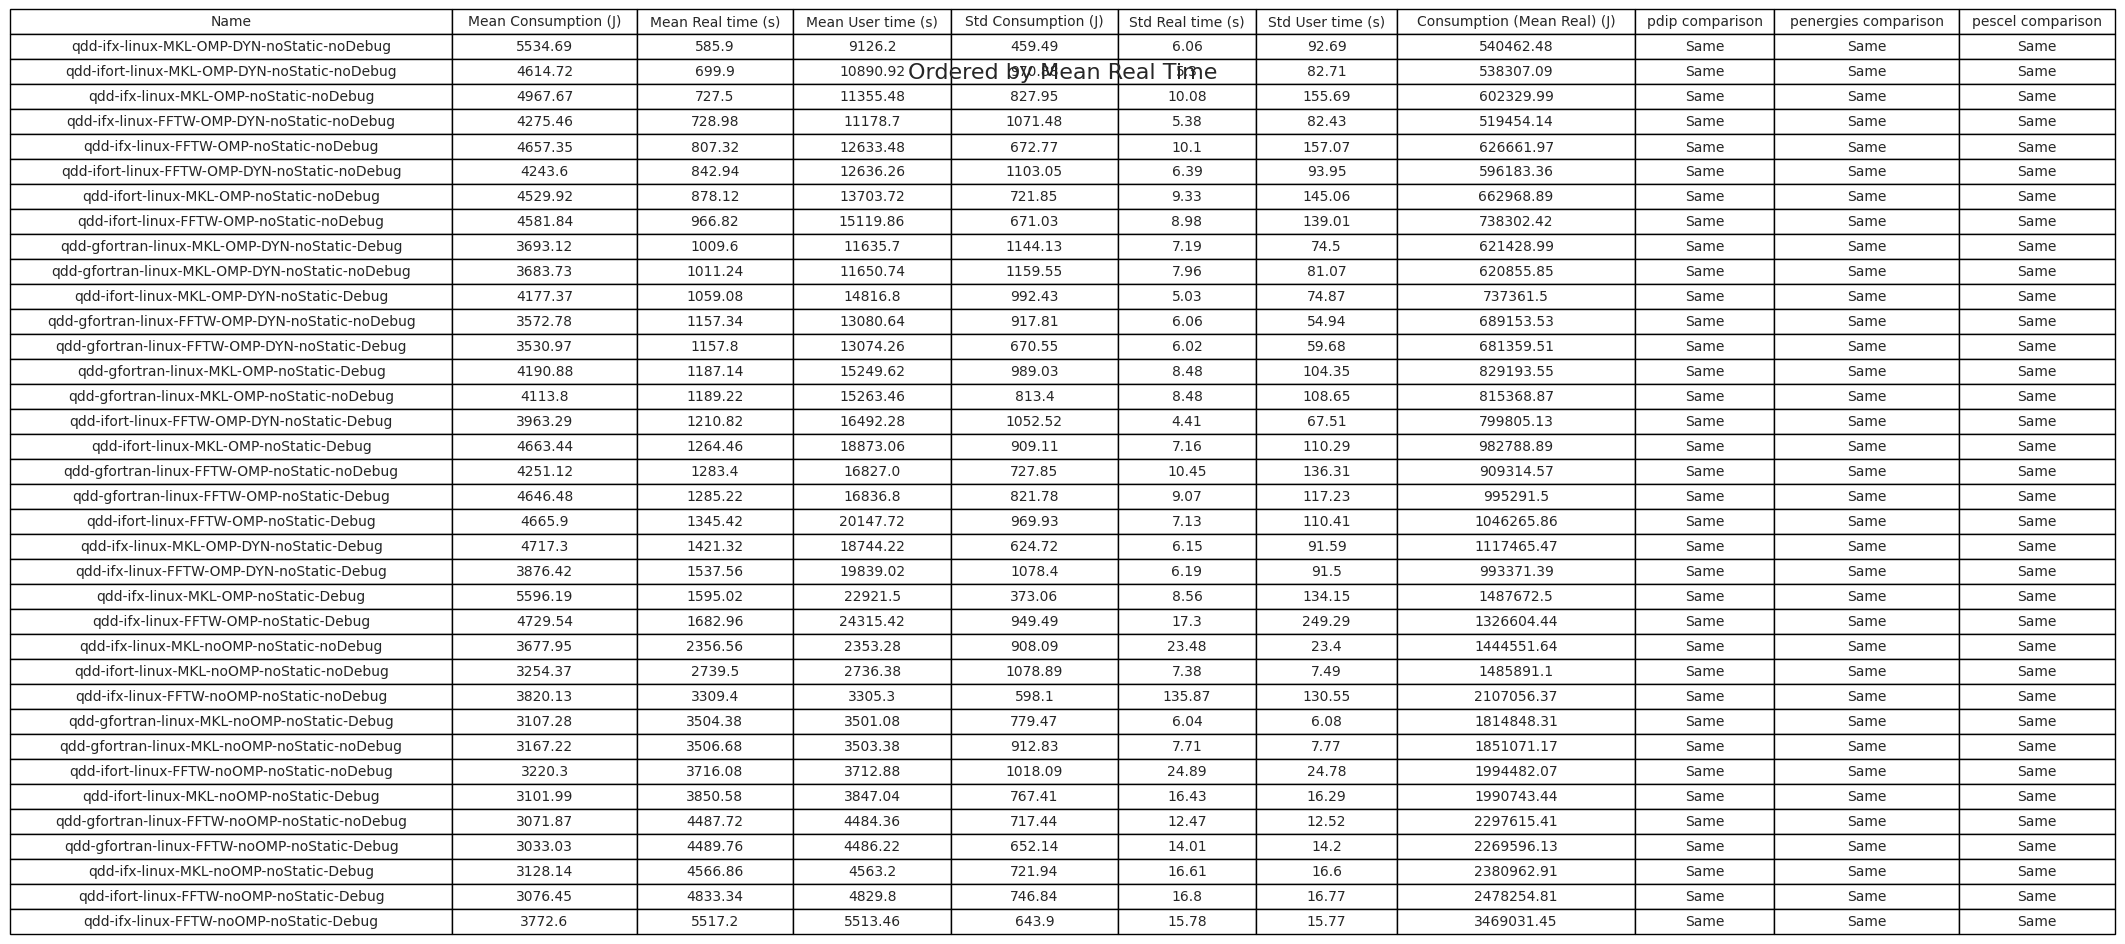

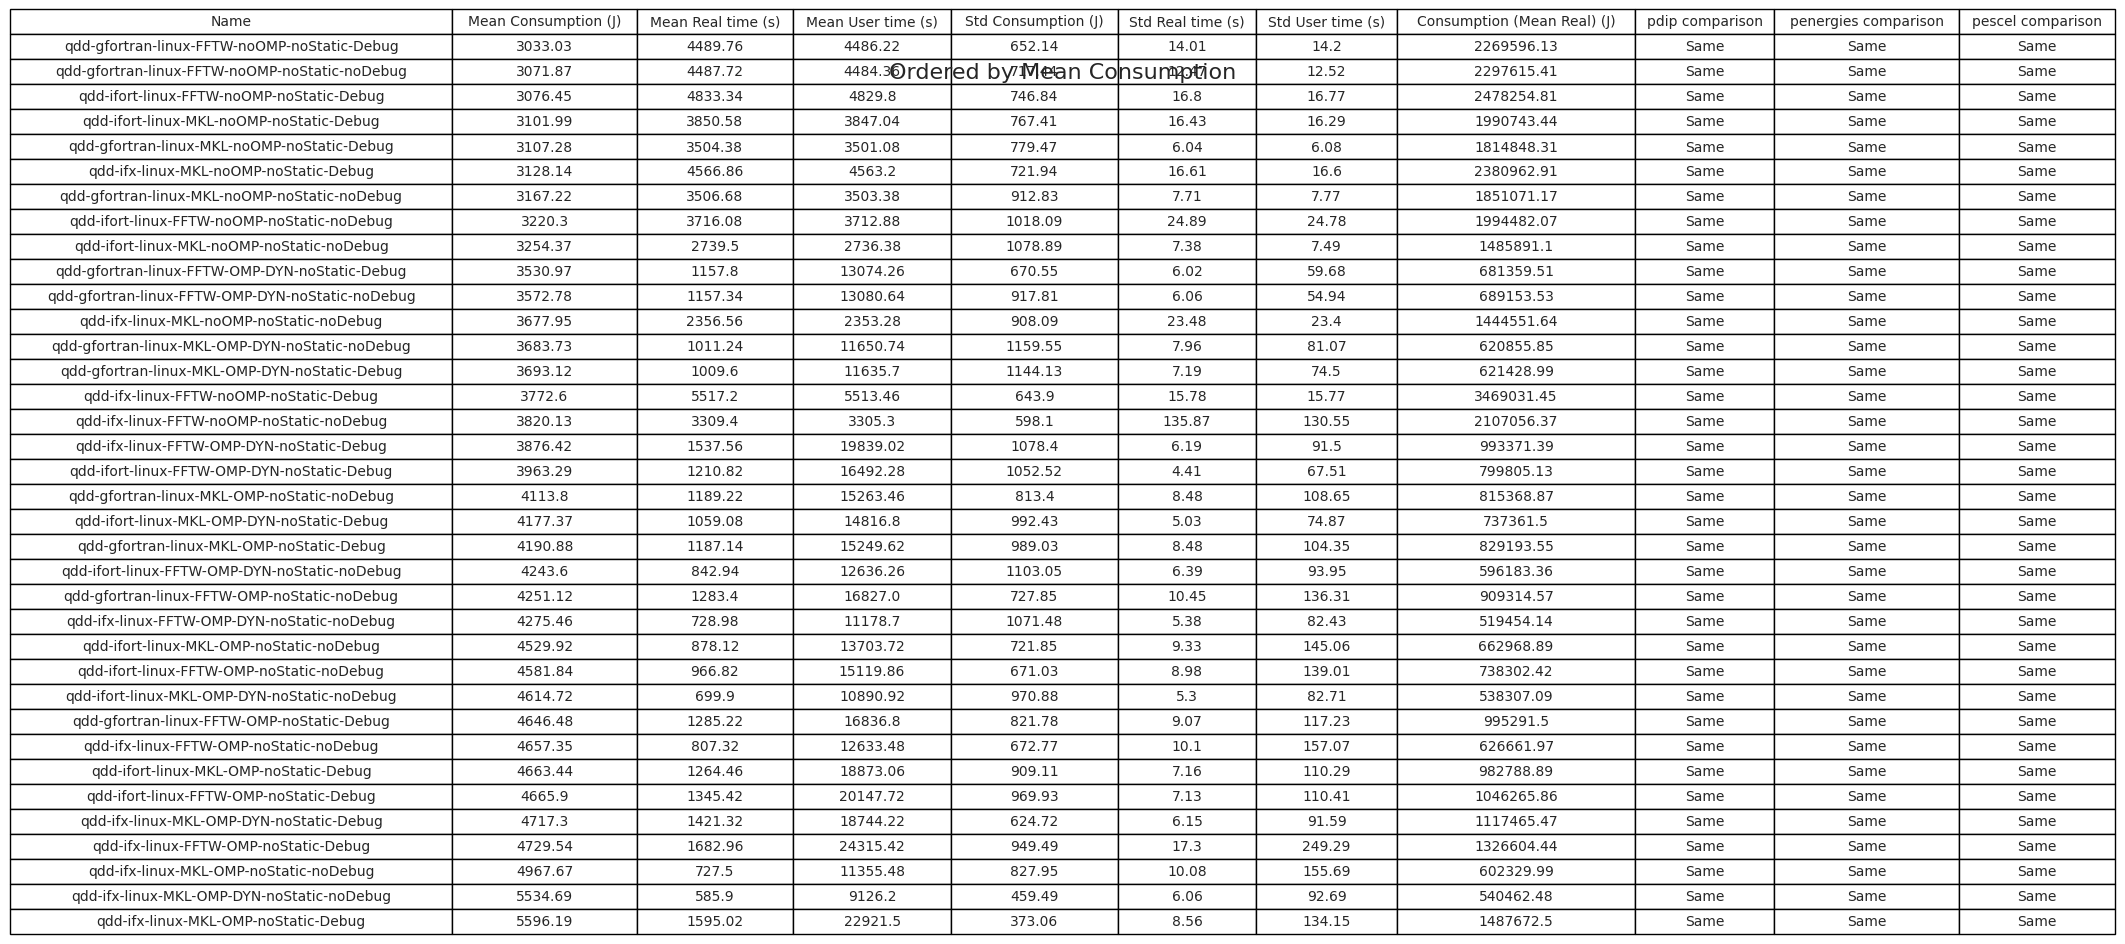

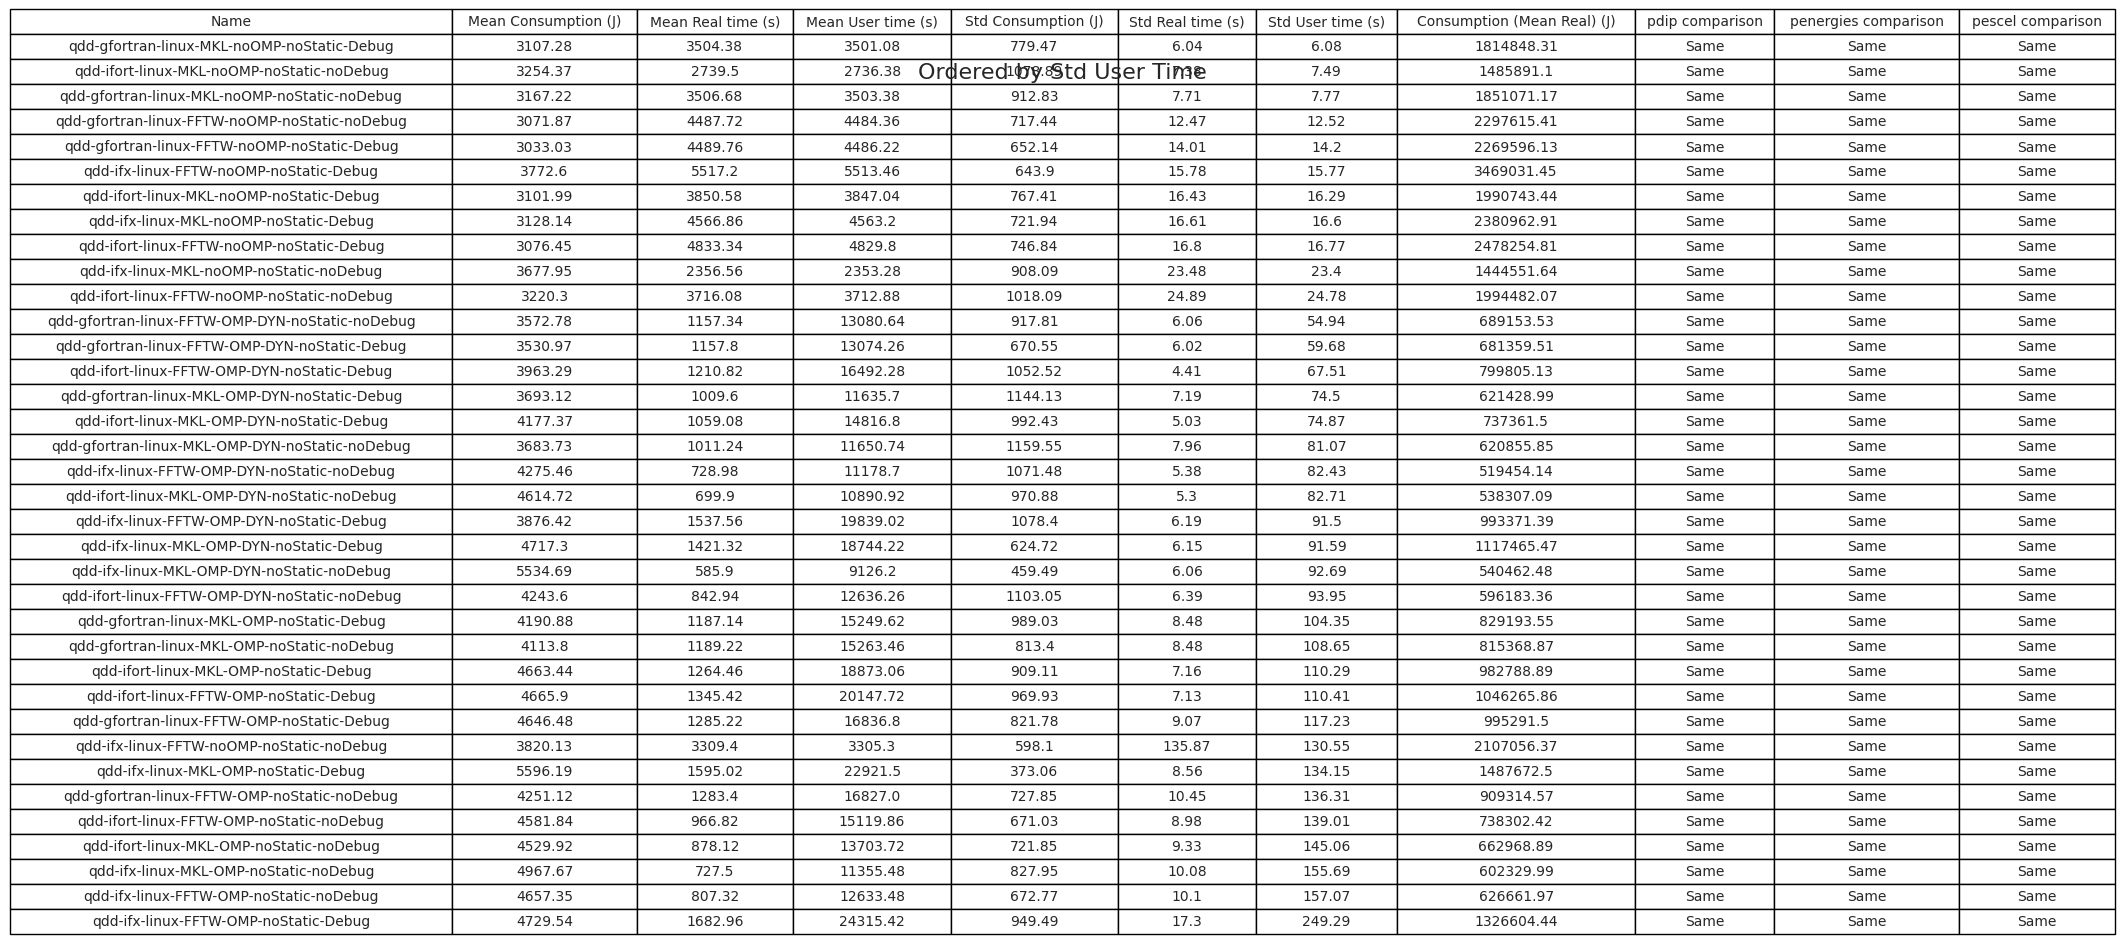

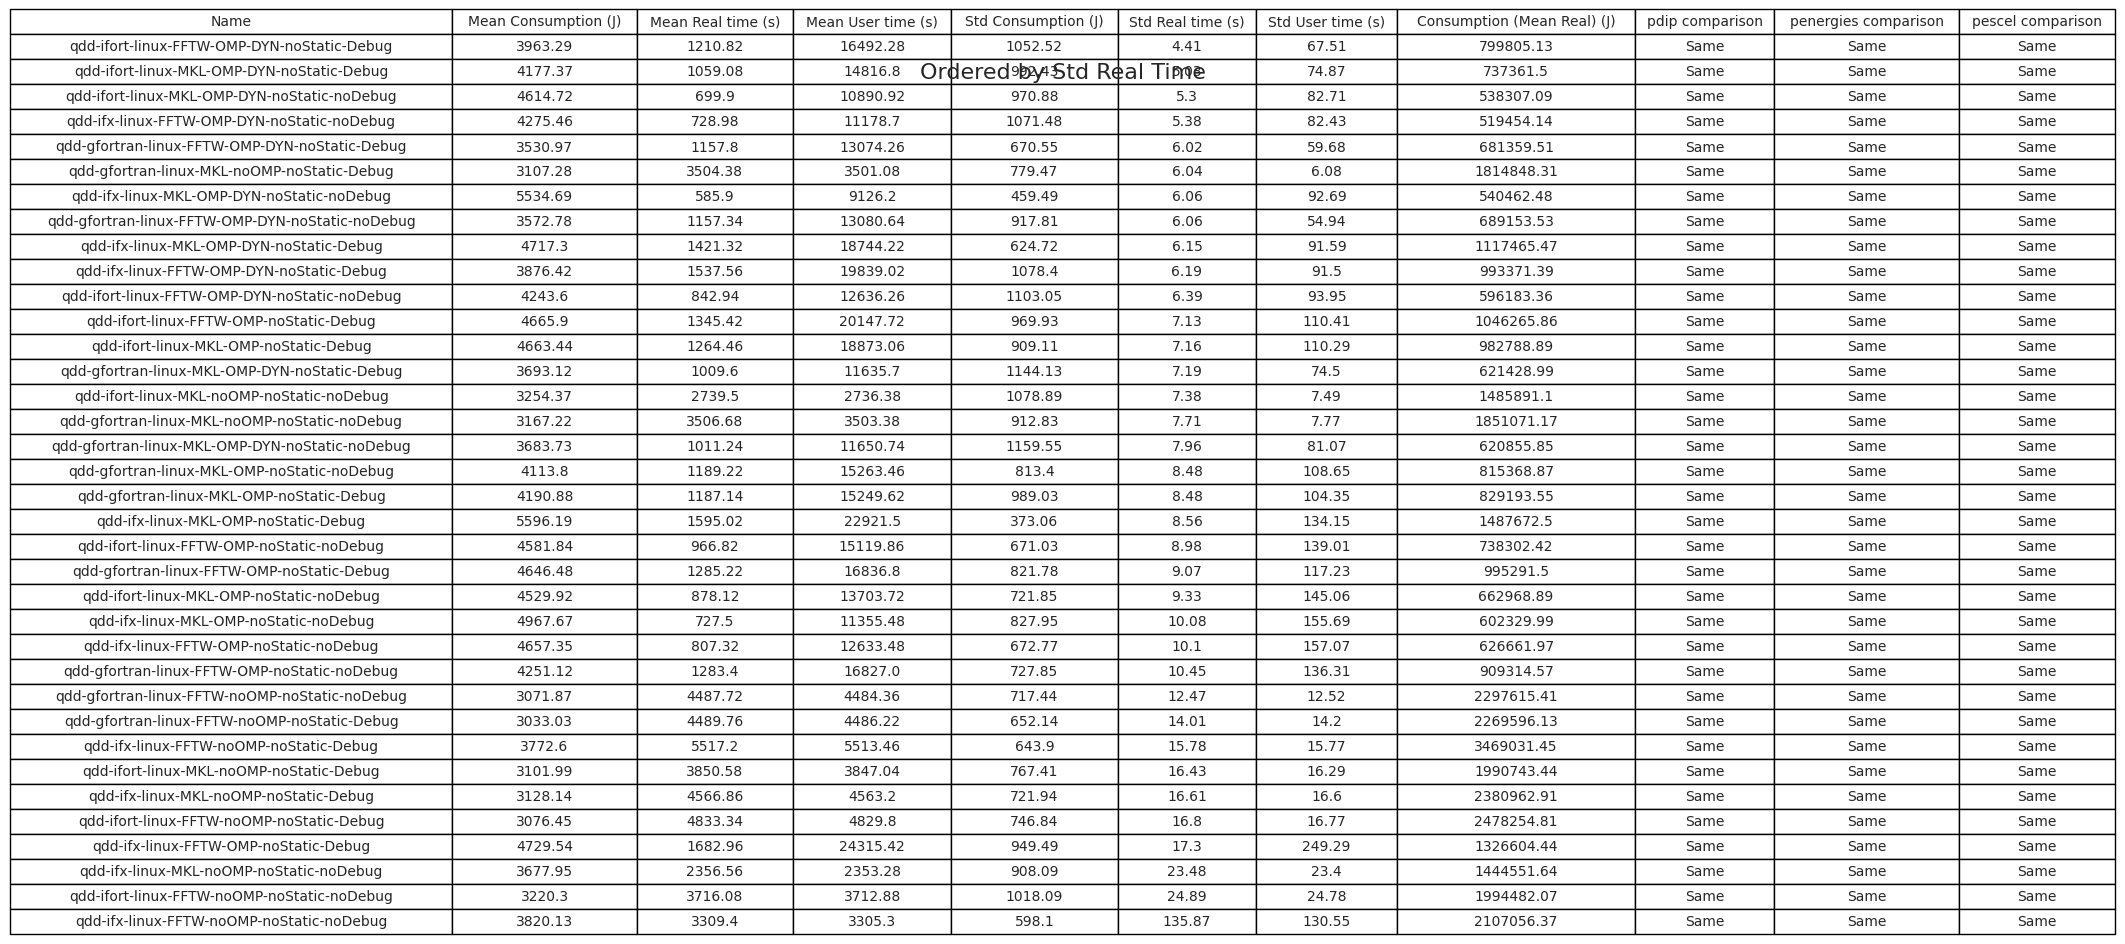

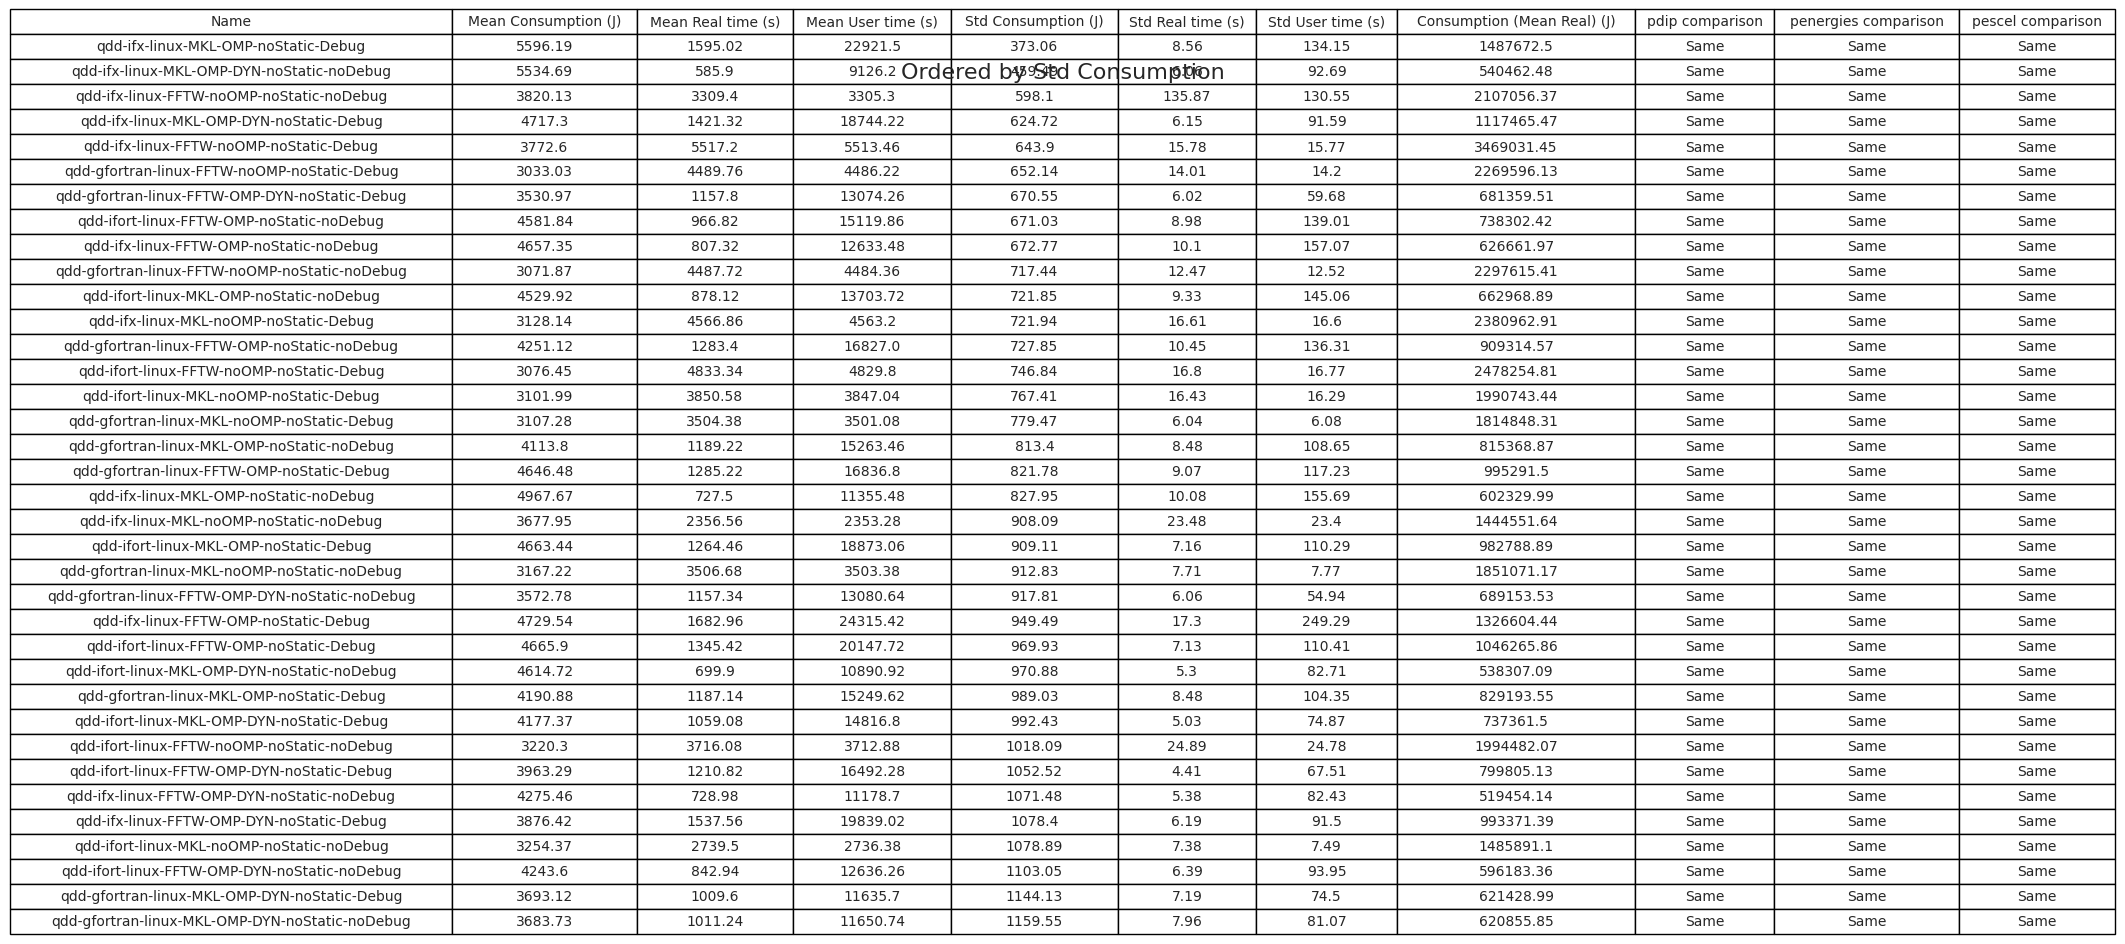

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import subprocess
import difflib
import warnings
warnings.filterwarnings('ignore')

def extract_from_result(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()[-10:]
        real_time_match = re.findall(r"real\s+(\d+)m(\d+),\d+s", ''.join(lines))
        user_time_match = re.findall(r"user\s+(\d+)m(\d+),\d+s", ''.join(lines))
        try:
            real_time = 60 * float(real_time_match[0][0]) + float(real_time_match[0][1])
            user_time = 60 * float(user_time_match[0][0]) + float(user_time_match[0][1])
        except:
            real_time = 1000
            user_time = 1000
    return real_time, user_time

def extract_from_consumption(filepath):
    with open(filepath, 'r') as f:
        for line in f.readlines():
            match = re.search(r"Total energy:\s+([\d\.]+)\s+Joules", line)
            if match:
                return float(match.group(1))
    return None

def extract_values(folder_path):
    real_time, user_time = extract_from_result(os.path.join(folder_path, "time.txt"))
    consumption = extract_from_consumption(os.path.join(folder_path, "consumption.txt"))
    return real_time, user_time, consumption

base_path = '.'  # current directory
df = pd.DataFrame(columns=["Name", "Real time (s)", "User time (s)", "Consumption (J)"])

for folder in os.listdir(base_path):
    if os.path.isdir(os.path.join(base_path, folder)):
        for rep in range(1, 51):
            full_path = os.path.join(base_path, folder, f"repli{rep}")
            if os.path.exists(full_path):
                real_time, user_time, consumption = extract_values(full_path)
                df.loc[len(df)] = {
                    "Name": f"{folder}-{rep}",
                    "Real time (s)": real_time,
                    "User time (s)": user_time,
                    "Consumption (J)": consumption
                }

# Group by experiment and compute means and standard deviations
non_numeric_cols = df.select_dtypes(include='object').columns
print(non_numeric_cols)
numeric_cols = df.columns.difference(non_numeric_cols)
#grouped = df.groupby(df['Name'].apply(lambda x: x.rsplit('-', 1)[0]))[numeric_cols].mean().round(2).reset_index()
grouped_mean = df.groupby(df['Name'].apply(lambda x: x.rsplit('-', 1)[0]))[numeric_cols].mean().round(2)
grouped_std = df.groupby(df['Name'].apply(lambda x: x.rsplit('-', 1)[0]))[numeric_cols].std().round(2)

# Renaming columns and merging mean and std dataframes
grouped = pd.concat([grouped_mean, grouped_std], axis=1, keys=('Mean', 'Std'))
grouped.columns = [' '.join(col).strip() for col in grouped.columns.values]

# Compute consumption during mean real time
grouped['Consumption (Mean Real) (J)'] = (((grouped['Mean Real time (s)']/60) * (grouped['Mean Consumption (J)']*10))).round(2)


# Before resetting the index:
experiments = grouped.index.tolist()  # Get the list of experiment names
print(experiments)

# Renaming columns for better clarity
grouped = grouped.reset_index().rename(columns={"index": "Experiment"})


def file_differs(file1, file2):
    # Run the diff command
    print("file1: " + str(file1))
    print("file2: " + str(file2))
    
    print("Absolute path for file1:", os.path.abspath(file1))
    print("Absolute path for file2:", os.path.abspath(file2))
    
    result = subprocess.run(['diff', file1, file2], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return result

def compare_files(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        lines1 = f1.readlines()
        lines2 = f2.readlines()

    for l1, l2 in zip(lines1, lines2):
        if l1 != l2:
            print(f"Files differ at line:")
            print(f"File1: {l1.strip()}")
            print(f"File2: {l2.strip()}")
            return "diff"

    # Check if one file has more lines than the other
    if len(lines1) != len(lines2):
        print(f"Files have different number of lines. File1 has {len(lines1)} lines. File2 has {len(lines2)} lines.")
        return "diff"

    print("Files are identical.")

def are_files_identical(base_path, experiment_name, filename):
    """Check if the files with the given filename are identical across all replications of the experiment."""
    first_file_path = None

    for rep in range(1, 51):
        replication_path = os.path.join(base_path, experiment_name, f"repli{rep}", filename)

        if first_file_path is None:
            first_file_path = replication_path  # set the first file as reference
        elif os.path.exists(replication_path):
            differences = compare_files(first_file_path, replication_path)
            if differences:
                print(f"Files {first_file_path} and {replication_path} are different.")
                return False  # Files are different
        else:
            print(f"File {replication_path} doesn't exist.")  # Debug Point 4
    
    print(f"All replication files for experiment '{experiment_name}' with filename '{filename}' are identical.")
    return True  # All files are the same


print(grouped)

# Use the fetched names directly in the loop to add comparison columns.
for experiment in experiments:
    for file_type in ["pdip.Na2-egs", "penergies.Na2-egs", "pescel.Na2-egs"]:
        column_name = f"{file_type.split('.')[0]} comparison"
        if are_files_identical(base_path, experiment, file_type):
            grouped.loc[grouped['Name'] == experiment, column_name] = "Same"
        else:
            grouped.loc[grouped['Name'] == experiment, column_name] = "Diff"




# Display and save the table with the mean values and std deviations
def display_and_save_table(df, filename, title=""):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.axis('off')
    ax.set_title(title, fontsize=16)
    tab = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tab.auto_set_font_size(False)
    # Adjust the width of the first column
    col_width = {idx: 0.2 for idx in range(len(df.columns))}
    col_width[0] = 0.4  # Set width of the first column to 0.4 (increase or decrease as needed)
    for idx, width in col_width.items():
        tab.auto_set_column_width(idx)
    tab.set_fontsize(10)
    tab.scale(1.5, 1.5)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

def display_and_save_table_ordered(df, order_by_column, filename, title=""):
    ordered_df = df.sort_values(by=order_by_column)
    display_and_save_table(ordered_df, filename, title)

# Display tables ordered by different metrics
display_and_save_table_ordered(grouped, 'Mean User time (s)', "ordered_by_mean_user_time.png", "Ordered by Mean User Time")
display_and_save_table_ordered(grouped, 'Mean Real time (s)', "ordered_by_mean_real_time.png", "Ordered by Mean Real Time")
display_and_save_table_ordered(grouped, 'Mean Consumption (J)', "ordered_by_mean_consumption.png", "Ordered by Mean Consumption")
display_and_save_table_ordered(grouped, 'Std User time (s)', "ordered_by_std_user_time.png", "Ordered by Std User Time")
display_and_save_table_ordered(grouped, 'Std Real time (s)', "ordered_by_std_real_time.png", "Ordered by Std Real Time")
display_and_save_table_ordered(grouped, 'Std Consumption (J)', "ordered_by_std_consumption.png", "Ordered by Std Consumption")



In [16]:
### Statistical analysis

    compiler library    OMP    dyn  debug
0   gfortran    FFTW   True   True   True
1   gfortran    FFTW   True   True  False
2   gfortran    FFTW   True  False   True
3   gfortran    FFTW   True  False  False
4   gfortran    FFTW  False  False   True
5   gfortran    FFTW  False  False  False
6   gfortran     MKL   True   True   True
7   gfortran     MKL   True   True  False
8   gfortran     MKL   True  False   True
9   gfortran     MKL   True  False  False
10  gfortran     MKL  False  False   True
11  gfortran     MKL  False  False  False
12     ifort    FFTW   True   True   True
13     ifort    FFTW   True   True  False
14     ifort    FFTW   True  False   True
15     ifort    FFTW   True  False  False
16     ifort    FFTW  False  False   True
17     ifort    FFTW  False  False  False
18     ifort     MKL   True   True   True
19     ifort     MKL   True   True  False
20     ifort     MKL   True  False   True
21     ifort     MKL   True  False  False
22     ifort     MKL  False  False

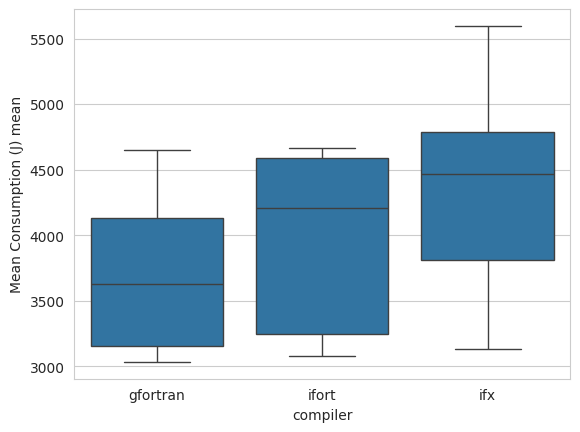

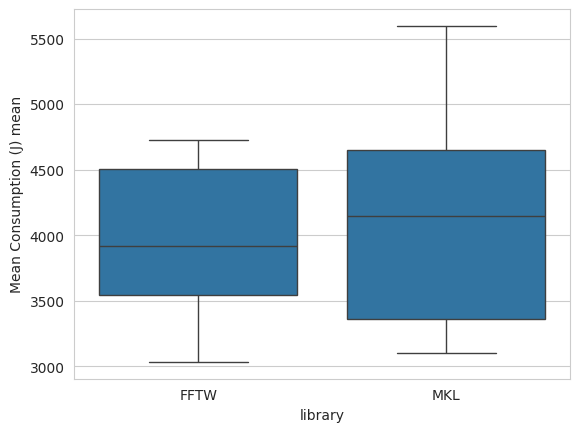

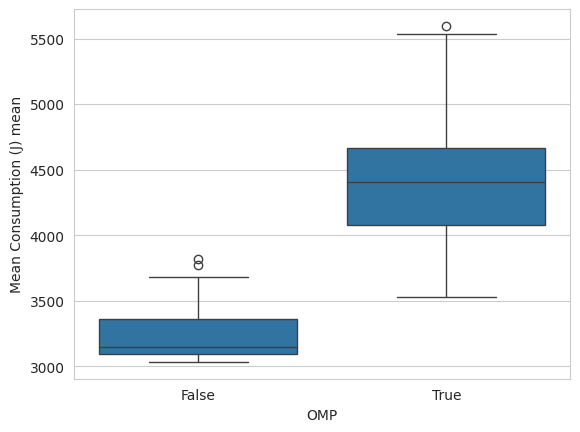

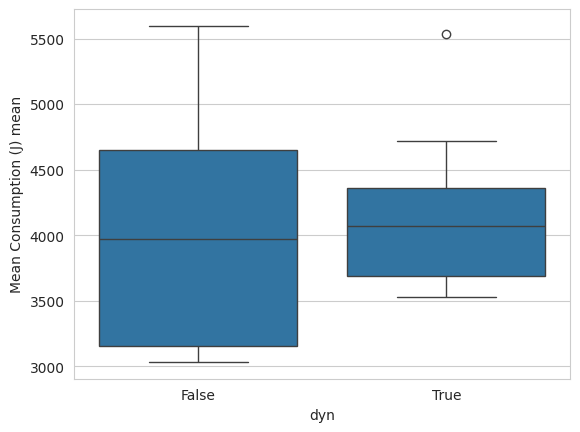

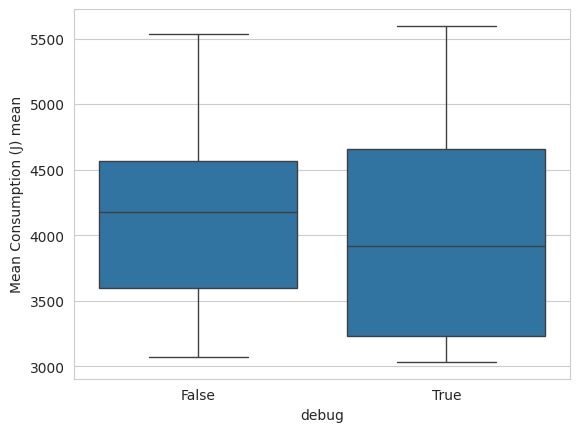

                   sum_sq    df           F        PR(>F)
C(compiler)  3.152845e+06   2.0   15.830298  2.252290e-05
C(library)   2.385753e+05   1.0    2.395752  1.325102e-01
C(OMP)       1.088484e+07   1.0  109.304585  2.382823e-11
C(dyn)       1.358828e+06   1.0   13.645229  9.120887e-04
C(debug)     6.830644e+04   1.0    0.685927  4.143174e-01
Residual     2.887896e+06  29.0         NaN           NaN


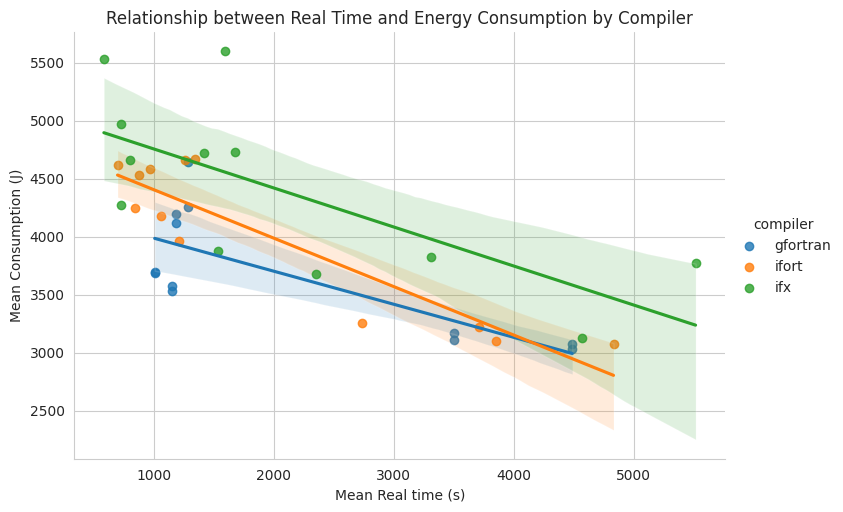

In [17]:
import pandas as pd
import numpy as np

# Assuming 'grouped' is your DataFrame
# Let's extract compiler, library, OMP, dyn, and debug mode as separate columns
def extract_features(name):
    parts = name.split('-')
    features = {
        'compiler': parts[1],
        'library': parts[3],
        'OMP': '-OMP' in name,
        'dyn': '-DYN' in name,
        'debug': '-Debug' in name,
    }
    return pd.Series(features)

features = grouped['Name'].apply(extract_features)
grouped = pd.concat([grouped, features], axis=1)

print(features)


print(grouped.columns)

print("OK")
import seaborn as sns
import matplotlib.pyplot as plt

#Remove duplicate columns (if any). Here's a way to keep the first of each duplicate column.
grouped = grouped.loc[:,~grouped.columns.duplicated()]




# Descriptive Statistics
grouped_stats = grouped.groupby(['compiler', 'library', 'OMP', 'dyn', 'debug']).agg({
    'Mean Consumption (J)': ['mean'],
    'Mean Real time (s)': ['mean'],
    'Mean User time (s)': ['mean']
}).reset_index()

print(grouped_stats)

# Mean of means for each compiler
mean_of_means_compiler = grouped_stats.groupby('compiler')['Mean Consumption (J)'].mean()
print("Mean of Means for each Compiler:")
print(mean_of_means_compiler)

# Mean of means for each library
mean_of_means_library = grouped_stats.groupby('library')['Mean Consumption (J)'].mean()
print("Mean of Means for each Library:")
print(mean_of_means_library)

# Mean of means for OMP (True/False)
mean_of_means_OMP = grouped_stats.groupby('OMP')['Mean Consumption (J)'].mean()
print("Mean of Means for OMP (True/False):")
print(mean_of_means_OMP)

# Mean of means for Dynamic Linking (True/False)
mean_of_means_dyn = grouped_stats.groupby('dyn')['Mean Consumption (J)'].mean()
print("Mean of Means for Dynamic Linking (True/False):")
print(mean_of_means_dyn)

# Mean of means for Debug Mode (True/False)
mean_of_means_debug = grouped_stats.groupby('debug')['Mean Consumption (J)'].mean()
print("Mean of Means for Debug Mode (True/False):")
print(mean_of_means_debug)


# Flattening the multi-level column headers
grouped_stats.columns = [' '.join(col).strip() for col in grouped_stats.columns.values]

# Visualizations: Box plots for energy consumption by compiler
sns.boxplot(x='compiler', y='Mean Consumption (J) mean', data=grouped_stats)
plt.savefig("MeanConsumptionByMin(J)-Compiler.png")
plt.show()


sns.boxplot(x='library', y='Mean Consumption (J) mean', data=grouped_stats)
plt.savefig("MeanConsumptionByMin(J)-Library.png")
plt.show()


sns.boxplot(x='OMP', y='Mean Consumption (J) mean', data=grouped_stats)
plt.savefig("MeanConsumptionByMin(J)-OMP.png")
plt.show()


sns.boxplot(x='dyn', y='Mean Consumption (J) mean', data=grouped_stats)
plt.savefig("MeanConsumptionByMin(J)-Dyn.png")
plt.show()


sns.boxplot(x='debug', y='Mean Consumption (J) mean', data=grouped_stats)
plt.savefig("MeanConsumptionByMin(J)-Debug.png")
plt.show()




# For comparative statistics and ANOVA, ensure your data is appropriately grouped and formatted.
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Rename the column for ease of use in the formula
grouped.rename(columns={'Mean Consumption (J)': 'Mean_Consumption_J'}, inplace=True)



# Now run the ANOVA with the updated column name
model = ols('Mean_Consumption_J ~ C(compiler) + C(library) + C(OMP) + C(dyn) + C(debug)', data=grouped).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

import seaborn as sns



# Rename the column for ease of use in the formula
grouped.rename(columns={'Mean_Consumption_J': 'Mean Consumption (J)'}, inplace=True)



sns.lmplot(x='Mean Real time (s)', y='Mean Consumption (J)', data=grouped, hue='compiler', aspect=1.5)
plt.title('Relationship between Real Time and Energy Consumption by Compiler')
plt.show()




Index(['compiler', 'library', 'OMP', 'dyn', 'debug',
       'Mean Consumption (J) mean', 'Mean Real time (s) mean',
       'Mean User time (s) mean'],
      dtype='object')
Mean of Means for each Compiler:
compiler
gfortran    2105.791667
ifort       1950.588333
ifx         2069.715000
Name: Mean Real time (s) mean, dtype: float64
Mean of Means for each Library:
library
FFTW    2242.226667
MKL     1841.836667
Name: Mean Real time (s) mean, dtype: float64
Mean of Means for OMP (True/False):
OMP
False    3906.505
True     1109.795
Name: Mean Real time (s) mean, dtype: float64
Mean of Means for Dynamic Linking (True/False):
dyn
False    2545.444167
True     1035.206667
Name: Mean Real time (s) mean, dtype: float64
Mean of Means for each Compiler:
compiler
gfortran    10799.438333
ifort       11483.893333
ifx         12154.105000
Name: Mean User time (s) mean, dtype: float64
Mean of Means for each Library:
library
FFTW    12139.636667
MKL     10818.654444
Name: Mean User time (s) mean, dty

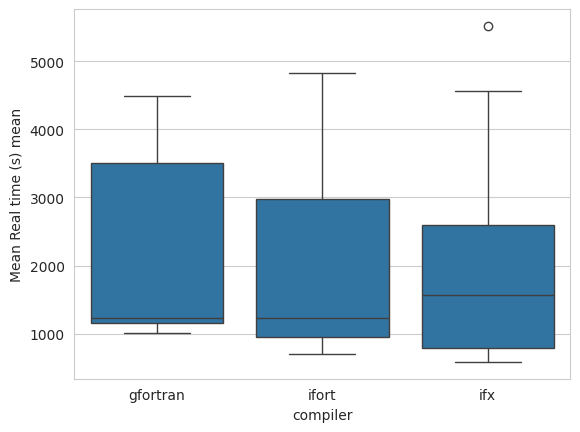

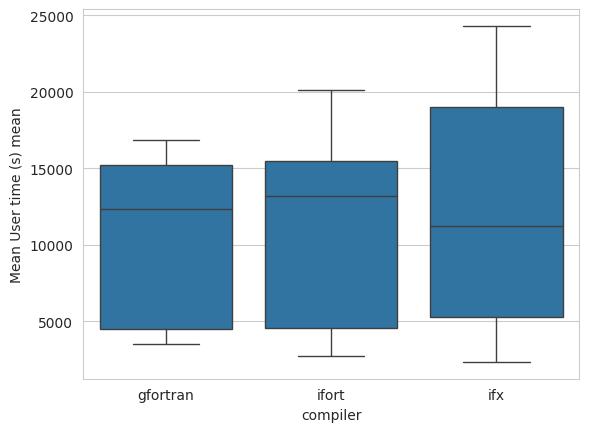

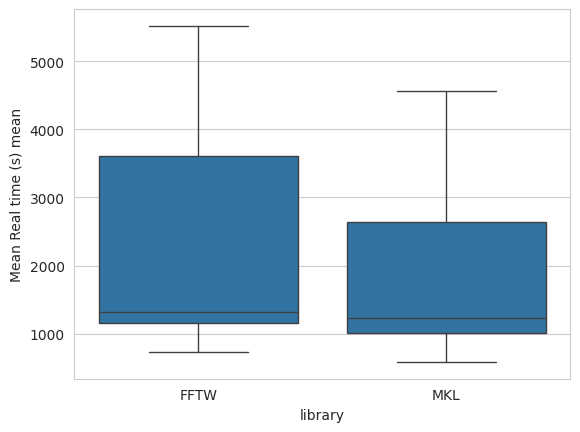

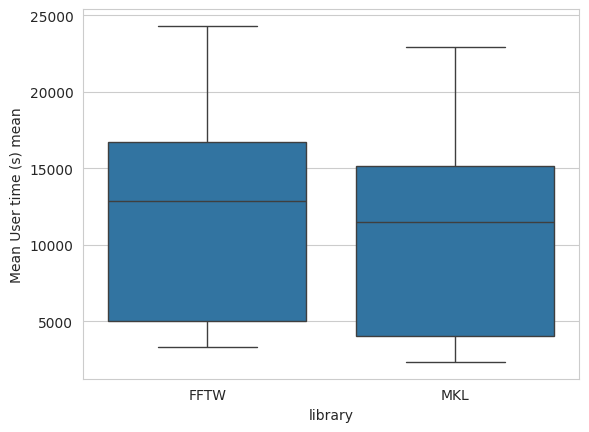

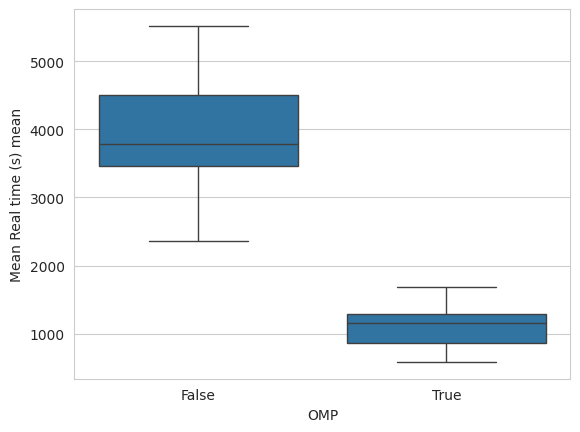

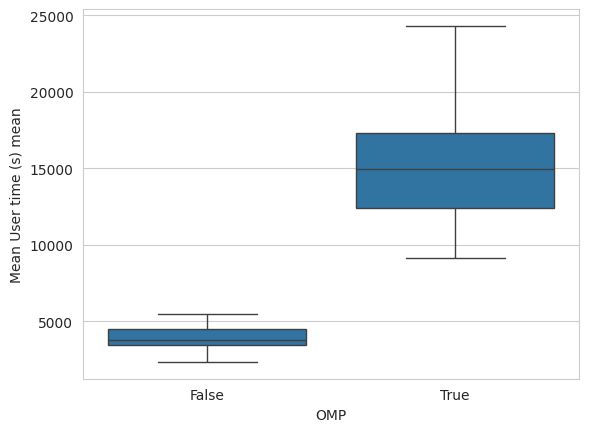

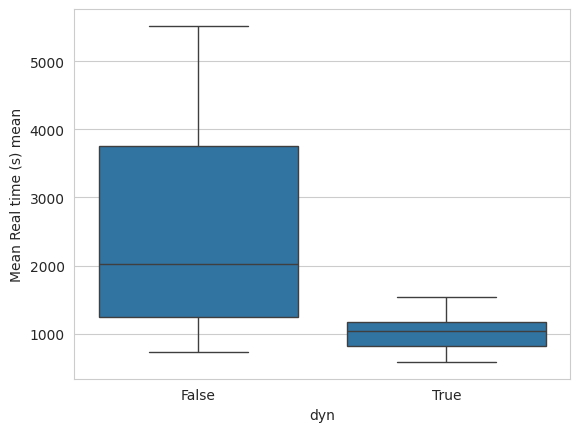

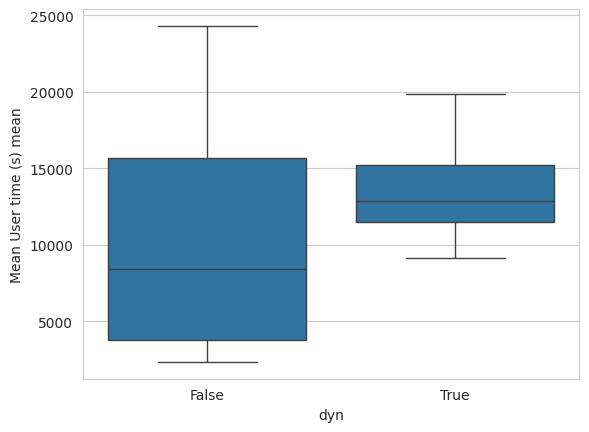

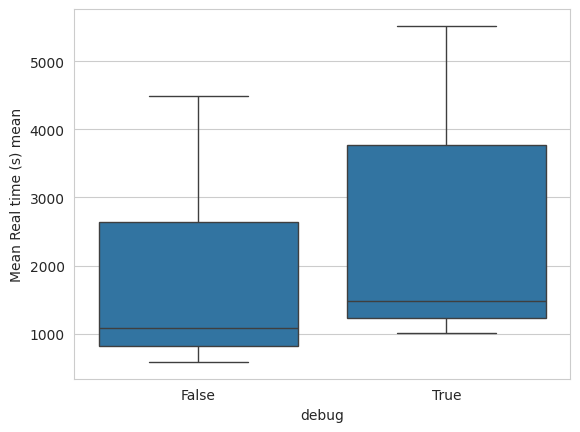

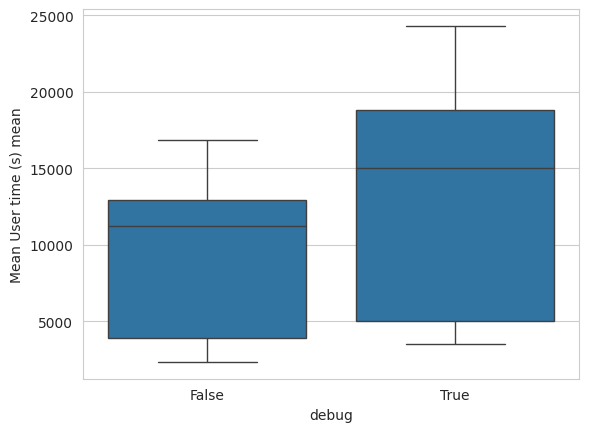

                   sum_sq    df           F        PR(>F)
C(compiler)  1.101114e+07   2.0    1.051320  3.624188e-01
C(library)   1.570495e+07   1.0    2.998951  9.394496e-02
C(OMP)       1.019347e+09   1.0  194.650156  2.143424e-14
C(dyn)       6.693821e+07   1.0   12.782239  1.250198e-03
C(debug)     1.214594e+08   1.0   23.193368  4.230207e-05
Residual     1.518676e+08  29.0         NaN           NaN
                   sum_sq    df           F        PR(>F)
C(compiler)  1.583231e+05   2.0    0.407774  6.688833e-01
C(library)   1.442809e+06   1.0    7.432151  1.075349e-02
C(OMP)       4.445968e+07   1.0  229.019188  2.672683e-15
C(dyn)       1.335221e+05   1.0    0.687794  4.136902e-01
C(debug)     3.688896e+06   1.0   19.002118  1.497533e-04
Residual     5.629793e+06  29.0         NaN           NaN


In [18]:
print(grouped_stats.columns)

# Mean of means for each compiler
mean_of_means_compiler = grouped_stats.groupby('compiler')['Mean Real time (s) mean'].mean()
print("Mean of Means for each Compiler:")
print(mean_of_means_compiler)

# Mean of means for each library
mean_of_means_library = grouped_stats.groupby('library')['Mean Real time (s) mean'].mean()
print("Mean of Means for each Library:")
print(mean_of_means_library)

# Mean of means for OMP (True/False)
mean_of_means_OMP = grouped_stats.groupby('OMP')['Mean Real time (s) mean'].mean()
print("Mean of Means for OMP (True/False):")
print(mean_of_means_OMP)

# Mean of means for Dynamic Linking (True/False)
mean_of_means_dyn = grouped_stats.groupby('dyn')['Mean Real time (s) mean'].mean()
print("Mean of Means for Dynamic Linking (True/False):")
print(mean_of_means_dyn)

# Mean of means for each compiler
mean_of_means_compiler = grouped_stats.groupby('compiler')['Mean User time (s) mean'].mean()
print("Mean of Means for each Compiler:")
print(mean_of_means_compiler)

# Mean of means for each library
mean_of_means_library = grouped_stats.groupby('library')['Mean User time (s) mean'].mean()
print("Mean of Means for each Library:")
print(mean_of_means_library)

# Mean of means for OMP (True/False)
mean_of_means_OMP = grouped_stats.groupby('OMP')['Mean User time (s) mean'].mean()
print("Mean of Means for OMP (True/False):")
print(mean_of_means_OMP)

# Mean of means for Dynamic Linking (True/False)
mean_of_means_dyn = grouped_stats.groupby('dyn')['Mean User time (s) mean'].mean()
print("Mean of Means for Dynamic Linking (True/False):")
print(mean_of_means_dyn)

# Mean of means for Debug Mode (True/False)
mean_of_means_debug = grouped_stats.groupby('debug')['Mean User time (s) mean'].mean()
print("Mean of Means for Debug Mode (True/False):")
print(mean_of_means_debug)

# Visualizations: Box plots for real time by compiler
sns.boxplot(x='compiler', y='Mean Real time (s) mean', data=grouped_stats)
plt.savefig("MeanRealTime(s)-Compiler.png")
plt.show()


# Visualizations: Box plots for user time by compiler
sns.boxplot(x='compiler', y='Mean User time (s) mean', data=grouped_stats)
plt.savefig("MeanUserTime(s)-Compiler.png")
plt.show()


# Visualizations: Box plots for real time by compiler
sns.boxplot(x='library', y='Mean Real time (s) mean', data=grouped_stats)
plt.savefig("MeanRealTime(s)-library.png")
plt.show()


# Visualizations: Box plots for user time by compiler
sns.boxplot(x='library', y='Mean User time (s) mean', data=grouped_stats)
plt.savefig("MeanUserTime(s)-library.png")
plt.show()


# Visualizations: Box plots for real time by compiler
sns.boxplot(x='OMP', y='Mean Real time (s) mean', data=grouped_stats)
plt.savefig("MeanRealTime(s)-omp.png")
plt.show()


# Visualizations: Box plots for user time by compiler
sns.boxplot(x='OMP', y='Mean User time (s) mean', data=grouped_stats)
plt.savefig("MeanUserTime(s)-omp.png")
plt.show()


# Visualizations: Box plots for real time by compiler
sns.boxplot(x='dyn', y='Mean Real time (s) mean', data=grouped_stats)
plt.savefig("MeanRealTime(s)-dyn.png")
plt.show()


# Visualizations: Box plots for user time by compiler
sns.boxplot(x='dyn', y='Mean User time (s) mean', data=grouped_stats)
plt.savefig("MeanUserTime(s)-dyn.png")
plt.show()



# Visualizations: Box plots for real time by compiler
sns.boxplot(x='debug', y='Mean Real time (s) mean', data=grouped_stats)
plt.savefig("MeanRealTime(s)-debug.png")
plt.show()


# Visualizations: Box plots for user time by compiler
sns.boxplot(x='debug', y='Mean User time (s) mean', data=grouped_stats)
plt.savefig("MeanUserTime(s)-debug.png")
plt.show()




# For comparative statistics and ANOVA, ensure your data is appropriately grouped and formatted.
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Rename columns for ease of use
grouped.rename(columns={
    'Mean User time (s)': 'Mean_User_time_s',
    'Mean Real time (s)': 'Mean_Real_time_s'
}, inplace=True)



# Now run the ANOVA with the updated column name
model = ols('Mean_User_time_s ~ C(compiler) + C(library) + C(OMP) + C(dyn) + C(debug)', data=grouped).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

model = ols('Mean_Real_time_s ~ C(compiler) + C(library) + C(OMP) + C(dyn) + C(debug)', data=grouped).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)




grouped.rename(columns={
    'Mean_User_time_s': 'Mean User time (s)',
    'Mean_Real_time_s': 'Mean Real time (s)'
}, inplace=True)


In [19]:
import pandas as pd



# Modify the check_diff function to return 'Diff', 'Same', and also calculate total appearances
def check_diff(row):
    if 'Diff' in [row['pdip comparison'], row['pescel comparison'], row['penergies comparison']]:
        return 'Diff'
    else:
        return 'Same'

# Apply the modified function
grouped['comparison_result'] = grouped.apply(check_diff, axis=1)


## Initialize a dictionary to hold counts
option_counts = {
    'compiler': {},
    'library': {},
    'OMP': {'Diff': {True: 0, False: 0}, 'Same': {True: 0, False: 0}, 'Total': {True: 0, False: 0}},
    'dyn': {'Diff': {True: 0, False: 0}, 'Same': {True: 0, False: 0}, 'Total': {True: 0, False: 0}},
    'debug': {'Diff': {True: 0, False: 0}, 'Same': {True: 0, False: 0}, 'Total': {True: 0, False: 0}}
}

# Function to initialize dictionary for new keys
def init_dict_counts():
    return {'Diff': 0, 'Same': 0, 'Total': 0}

# Count occurrences
for index, row in grouped.iterrows():
    # Compiler
    comp = row['compiler']
    if comp not in option_counts['compiler']:
        option_counts['compiler'][comp] = init_dict_counts()
    option_counts['compiler'][comp][row['comparison_result']] += 1
    option_counts['compiler'][comp]['Total'] += 1

    # Library
    lib = row['library']
    if lib not in option_counts['library']:
        option_counts['library'][lib] = init_dict_counts()
    option_counts['library'][lib][row['comparison_result']] += 1
    option_counts['library'][lib]['Total'] += 1

    # OMP, dyn, debug
    for option in ['OMP', 'dyn', 'debug']:
        option_counts[option][row['comparison_result']][row[option]] += 1
        option_counts[option]['Total'][row[option]] += 1

# Print the updated counts
for option, counts in option_counts.items():
    print(f"{option}: {counts}")

    

compiler: {'gfortran': {'Diff': 0, 'Same': 12, 'Total': 12}, 'ifort': {'Diff': 0, 'Same': 12, 'Total': 12}, 'ifx': {'Diff': 0, 'Same': 12, 'Total': 12}}
library: {'FFTW': {'Diff': 0, 'Same': 18, 'Total': 18}, 'MKL': {'Diff': 0, 'Same': 18, 'Total': 18}}
OMP: {'Diff': {True: 0, False: 0}, 'Same': {True: 24, False: 12}, 'Total': {True: 24, False: 12}}
dyn: {'Diff': {True: 0, False: 0}, 'Same': {True: 12, False: 24}, 'Total': {True: 12, False: 24}}
debug: {'Diff': {True: 0, False: 0}, 'Same': {True: 18, False: 18}, 'Total': {True: 18, False: 18}}


In [20]:
print(grouped)
print(grouped.columns)

                                                Name  Mean Consumption (J)  \
0     qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug               3530.97   
1   qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug               3572.78   
2         qdd-gfortran-linux-FFTW-OMP-noStatic-Debug               4646.48   
3       qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug               4251.12   
4       qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug               3033.03   
5     qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug               3071.87   
6      qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug               3693.12   
7    qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug               3683.73   
8          qdd-gfortran-linux-MKL-OMP-noStatic-Debug               4190.88   
9        qdd-gfortran-linux-MKL-OMP-noStatic-noDebug               4113.80   
10       qdd-gfortran-linux-MKL-noOMP-noStatic-Debug               3107.28   
11     qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug            

In [21]:
print(reshaped_df)
print(reshaped_df.columns)

                                          Experiment  Real time 1 (s)  \
0     qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug           1158.0   
1   qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug           1148.0   
2         qdd-gfortran-linux-FFTW-OMP-noStatic-Debug           1280.0   
3       qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug           1299.0   
4       qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug           4519.0   
5     qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug           4508.0   
6      qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug           1017.0   
7    qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug           1014.0   
8          qdd-gfortran-linux-MKL-OMP-noStatic-Debug           1183.0   
9        qdd-gfortran-linux-MKL-OMP-noStatic-noDebug           1199.0   
10       qdd-gfortran-linux-MKL-noOMP-noStatic-Debug           3511.0   
11     qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug           3499.0   
12       qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debu

In [22]:
print(reshaped_df)
reshaped_df.to_csv("fullExperimentValues.csv", index=False)

                                          Experiment  Real time 1 (s)  \
0     qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug           1158.0   
1   qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug           1148.0   
2         qdd-gfortran-linux-FFTW-OMP-noStatic-Debug           1280.0   
3       qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug           1299.0   
4       qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug           4519.0   
5     qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug           4508.0   
6      qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug           1017.0   
7    qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug           1014.0   
8          qdd-gfortran-linux-MKL-OMP-noStatic-Debug           1183.0   
9        qdd-gfortran-linux-MKL-OMP-noStatic-noDebug           1199.0   
10       qdd-gfortran-linux-MKL-noOMP-noStatic-Debug           3511.0   
11     qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug           3499.0   
12       qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debu

In [23]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Function to extract and create descriptive names for features
def extract_features(name):
    parts = name.split('-')
    features = {
        'compiler': parts[1],
        'library': parts[3],
        'OMP': 'OMP' if '-OMP' in name else 'noOMP',
        'dyn': 'DYN' if '-DYN' in name else 'noDYN',
        'debug': 'Debug' if '-Debug' in name else 'noDebug',
    }
    return pd.Series(features)

# Apply the extract_features function to each row
features_df = reshaped_df['Experiment'].apply(extract_features)
reshaped_df = pd.concat([reshaped_df, features_df], axis=1)

# Initialize dictionary for results
aggregated_results = {}

# Function to concatenate measure values
def concatenate_measure_values(df, measure_prefix):
    concatenated_values = []
    for i in range(1, 51):
        column_name = f'{measure_prefix} {i} (s)' if 'time' in measure_prefix else f'{measure_prefix} {i} (J)'
        concatenated_values.extend(df[column_name].values)
    return concatenated_values

# Group by each feature and measure
features = ['compiler', 'library', 'OMP', 'dyn', 'debug']
measures = ['Real time', 'User time', 'Consumption']

for feature in features:
    for measure in measures:
        for name, group in reshaped_df.groupby(feature):
            values = concatenate_measure_values(group, measure)
            # Construct key with descriptive names
            key = f"{name}-{measure.replace(' ', '_')}"
            aggregated_results[key] = values
            
            # Save to CSV with descriptive naming
            output_df = pd.DataFrame({key: values})
            filename = f"{key}.csv"
            output_df.to_csv(filename, index=False)
            print(f"Saved {filename} with {len(values)} values.")

            


Saved gfortran-Real_time.csv with 600 values.
Saved ifort-Real_time.csv with 600 values.
Saved ifx-Real_time.csv with 600 values.
Saved gfortran-User_time.csv with 600 values.
Saved ifort-User_time.csv with 600 values.
Saved ifx-User_time.csv with 600 values.
Saved gfortran-Consumption.csv with 600 values.
Saved ifort-Consumption.csv with 600 values.
Saved ifx-Consumption.csv with 600 values.
Saved FFTW-Real_time.csv with 900 values.
Saved MKL-Real_time.csv with 900 values.
Saved FFTW-User_time.csv with 900 values.
Saved MKL-User_time.csv with 900 values.
Saved FFTW-Consumption.csv with 900 values.
Saved MKL-Consumption.csv with 900 values.
Saved OMP-Real_time.csv with 1200 values.
Saved noOMP-Real_time.csv with 600 values.
Saved OMP-User_time.csv with 1200 values.
Saved noOMP-User_time.csv with 600 values.
Saved OMP-Consumption.csv with 1200 values.
Saved noOMP-Consumption.csv with 600 values.
Saved DYN-Real_time.csv with 600 values.
Saved noDYN-Real_time.csv with 1200 values.
Saved D

In [24]:
# Calculate and print the mean "Real time" value for each list
for key, values in aggregated_results.items():
    if "Real_time" in key:
        mean_value = pd.Series(values).mean()  # Convert to Series for easy mean calculation
        print(f"Mean 'Real time' for {key}: {mean_value:.2f}")


Mean 'Real time' for gfortran-Real_time: 2105.79
Mean 'Real time' for ifort-Real_time: 1950.59
Mean 'Real time' for ifx-Real_time: 2069.72
Mean 'Real time' for FFTW-Real_time: 2242.23
Mean 'Real time' for MKL-Real_time: 1841.84
Mean 'Real time' for OMP-Real_time: 1109.80
Mean 'Real time' for noOMP-Real_time: 3906.51
Mean 'Real time' for DYN-Real_time: 1035.21
Mean 'Real time' for noDYN-Real_time: 2545.44
Mean 'Real time' for Debug-Real_time: 2362.14
Mean 'Real time' for noDebug-Real_time: 1721.92


In [25]:
print(grouped)

                                                Name  Mean Consumption (J)  \
0     qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug               3530.97   
1   qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug               3572.78   
2         qdd-gfortran-linux-FFTW-OMP-noStatic-Debug               4646.48   
3       qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug               4251.12   
4       qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug               3033.03   
5     qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug               3071.87   
6      qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug               3693.12   
7    qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug               3683.73   
8          qdd-gfortran-linux-MKL-OMP-noStatic-Debug               4190.88   
9        qdd-gfortran-linux-MKL-OMP-noStatic-noDebug               4113.80   
10       qdd-gfortran-linux-MKL-noOMP-noStatic-Debug               3107.28   
11     qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug            

In [26]:
print(grouped.columns)

Index(['Name', 'Mean Consumption (J)', 'Mean Real time (s)',
       'Mean User time (s)', 'Std Consumption (J)', 'Std Real time (s)',
       'Std User time (s)', 'Consumption (Mean Real) (J)', 'pdip comparison',
       'penergies comparison', 'pescel comparison', 'compiler', 'library',
       'OMP', 'dyn', 'debug', 'comparison_result'],
      dtype='object')


In [27]:
import pandas as pd

# Assuming you have a DataFrame named 'df'

# Keep only the first 4 columns of the DataFrame
df_reduced = grouped.iloc[:, :4]

# Save the reduced DataFrame to a CSV file
df_reduced.to_csv('reduced_dataframe.csv', index=False)  # Set index=False to avoid saving the index to the file


In [28]:
print(df_reduced)

                                                Name  Mean Consumption (J)  \
0     qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug               3530.97   
1   qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug               3572.78   
2         qdd-gfortran-linux-FFTW-OMP-noStatic-Debug               4646.48   
3       qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug               4251.12   
4       qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug               3033.03   
5     qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug               3071.87   
6      qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug               3693.12   
7    qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug               3683.73   
8          qdd-gfortran-linux-MKL-OMP-noStatic-Debug               4190.88   
9        qdd-gfortran-linux-MKL-OMP-noStatic-noDebug               4113.80   
10       qdd-gfortran-linux-MKL-noOMP-noStatic-Debug               3107.28   
11     qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug            

In [29]:
print(reshaped_df)

                                          Experiment  Real time 1 (s)  \
0     qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug           1158.0   
1   qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug           1148.0   
2         qdd-gfortran-linux-FFTW-OMP-noStatic-Debug           1280.0   
3       qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug           1299.0   
4       qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug           4519.0   
5     qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug           4508.0   
6      qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug           1017.0   
7    qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug           1014.0   
8          qdd-gfortran-linux-MKL-OMP-noStatic-Debug           1183.0   
9        qdd-gfortran-linux-MKL-OMP-noStatic-noDebug           1199.0   
10       qdd-gfortran-linux-MKL-noOMP-noStatic-Debug           3511.0   
11     qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug           3499.0   
12       qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debu

In [30]:
print(reshaped_df.columns)

Index(['Experiment', 'Real time 1 (s)', 'User time 1 (s)', 'Consumption 1 (J)',
       'Real time 2 (s)', 'User time 2 (s)', 'Consumption 2 (J)',
       'Real time 3 (s)', 'User time 3 (s)', 'Consumption 3 (J)',
       ...
       'Mean User time (s)', 'Std User time (s)', 'Std Consumption (J)',
       'Consumption (Mean Real) (J)', 'Consumption (Mean User) (J)',
       'compiler', 'library', 'OMP', 'dyn', 'debug'],
      dtype='object', length=163)


In [31]:
import pandas as pd


# Step 1: Remove the last five columns
#columns_to_drop = ['compiler', 'library', 'OMP', 'dyn', 'debug']
#reshaped_df.drop(columns=columns_to_drop, inplace=True)

# Step 2: Create separate DataFrames for Real time, User time, and Consumption
# Include the 'Experiment' column with each DataFrame
reshaped_df_Real_time = reshaped_df[['Experiment'] + reshaped_df.filter(regex='Real time \d+ \(s\)').columns.tolist()]
reshaped_df_User_time = reshaped_df[['Experiment'] + reshaped_df.filter(regex='User time \d+ \(s\)').columns.tolist()]
reshaped_df_Consumption = reshaped_df[['Experiment'] + reshaped_df.filter(regex='Consumption \d+ \(J\)').columns.tolist()]



# Step 3: Calculate the mean and variance for each type of data
# Adding mean and variance columns to each DataFrame
reshaped_df_Real_time['Mean Real time (s)'] = reshaped_df_Real_time.filter(regex='Real time \d+ \(s\)').mean(axis=1)
reshaped_df_Real_time['Variance Real time (s)'] = reshaped_df_Real_time.filter(regex='Real time \d+ \(s\)').var(axis=1)

reshaped_df_User_time['Mean User time (s)'] = reshaped_df_User_time.filter(regex='User time \d+ \(s\)').mean(axis=1)
reshaped_df_User_time['Variance User time (s)'] = reshaped_df_User_time.filter(regex='User time \d+ \(s\)').var(axis=1)

reshaped_df_Consumption['Mean Consumption (J)'] = reshaped_df_Consumption.filter(regex='Consumption \d+ \(J\)').mean(axis=1)
reshaped_df_Consumption['Variance Consumption (J)'] = reshaped_df_Consumption.filter(regex='Consumption \d+ \(J\)').var(axis=1)

print(reshaped_df_Real_time)
print(reshaped_df_User_time)
print(reshaped_df_Consumption)


                                          Experiment  Real time 1 (s)  \
0     qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug           1158.0   
1   qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug           1148.0   
2         qdd-gfortran-linux-FFTW-OMP-noStatic-Debug           1280.0   
3       qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug           1299.0   
4       qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug           4519.0   
5     qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug           4508.0   
6      qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug           1017.0   
7    qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug           1014.0   
8          qdd-gfortran-linux-MKL-OMP-noStatic-Debug           1183.0   
9        qdd-gfortran-linux-MKL-OMP-noStatic-noDebug           1199.0   
10       qdd-gfortran-linux-MKL-noOMP-noStatic-Debug           3511.0   
11     qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug           3499.0   
12       qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debu

In [32]:
# Print the column names of the DataFrame
print(reshaped_df_Real_time.columns)

# Export DataFrames to CSV files
reshaped_df_Real_time.to_csv('reshaped_df_Real_time.csv')
reshaped_df_User_time.to_csv('reshaped_df_User_time.csv')
reshaped_df_Consumption.to_csv('reshaped_df_Consumption.csv')


Index(['Experiment', 'Real time 1 (s)', 'Real time 2 (s)', 'Real time 3 (s)',
       'Real time 4 (s)', 'Real time 5 (s)', 'Real time 6 (s)',
       'Real time 7 (s)', 'Real time 8 (s)', 'Real time 9 (s)',
       'Real time 10 (s)', 'Real time 11 (s)', 'Real time 12 (s)',
       'Real time 13 (s)', 'Real time 14 (s)', 'Real time 15 (s)',
       'Real time 16 (s)', 'Real time 17 (s)', 'Real time 18 (s)',
       'Real time 19 (s)', 'Real time 20 (s)', 'Real time 21 (s)',
       'Real time 22 (s)', 'Real time 23 (s)', 'Real time 24 (s)',
       'Real time 25 (s)', 'Real time 26 (s)', 'Real time 27 (s)',
       'Real time 28 (s)', 'Real time 29 (s)', 'Real time 30 (s)',
       'Real time 31 (s)', 'Real time 32 (s)', 'Real time 33 (s)',
       'Real time 34 (s)', 'Real time 35 (s)', 'Real time 36 (s)',
       'Real time 37 (s)', 'Real time 38 (s)', 'Real time 39 (s)',
       'Real time 40 (s)', 'Real time 41 (s)', 'Real time 42 (s)',
       'Real time 43 (s)', 'Real time 44 (s)', 'Real time

In [33]:
import pandas as pd
from scipy.stats import levene, ttest_ind



# Define the experiment lists for each compiler
gfortran_experiments = [
    "qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug",
    "qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug",
    "qdd-gfortran-linux-FFTW-OMP-noStatic-Debug",
    "qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug",
    "qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug",
    "qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug",
    "qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug",
    "qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug",
    "qdd-gfortran-linux-MKL-OMP-noStatic-Debug",
    "qdd-gfortran-linux-MKL-OMP-noStatic-noDebug",
    "qdd-gfortran-linux-MKL-noOMP-noStatic-Debug",
    "qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug"
]

ifort_experiments = [
    "qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debug",
    "qdd-ifort-linux-FFTW-OMP-DYN-noStatic-noDebug",
    "qdd-ifort-linux-FFTW-OMP-noStatic-Debug",
    "qdd-ifort-linux-FFTW-OMP-noStatic-noDebug",
    "qdd-ifort-linux-FFTW-noOMP-noStatic-Debug",
    "qdd-ifort-linux-FFTW-noOMP-noStatic-noDebug",
    "qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug",
    "qdd-ifort-linux-MKL-OMP-DYN-noStatic-noDebug",
    "qdd-ifort-linux-MKL-OMP-noStatic-Debug",
    "qdd-ifort-linux-MKL-OMP-noStatic-noDebug",
    "qdd-ifort-linux-MKL-noOMP-noStatic-Debug",
    "qdd-ifort-linux-MKL-noOMP-noStatic-noDebug"
]

ifx_experiments = [
    "qdd-ifx-linux-FFTW-OMP-DYN-noStatic-Debug",
    "qdd-ifx-linux-FFTW-OMP-DYN-noStatic-noDebug",
    "qdd-ifx-linux-FFTW-OMP-noStatic-Debug",
    "qdd-ifx-linux-FFTW-OMP-noStatic-noDebug",
    "qdd-ifx-linux-FFTW-noOMP-noStatic-Debug",
    "qdd-ifx-linux-FFTW-noOMP-noStatic-noDebug",
    "qdd-ifx-linux-MKL-OMP-DYN-noStatic-Debug",
    "qdd-ifx-linux-MKL-OMP-DYN-noStatic-noDebug",
    "qdd-ifx-linux-MKL-OMP-noStatic-Debug",
    "qdd-ifx-linux-MKL-OMP-noStatic-noDebug",
    "qdd-ifx-linux-MKL-noOMP-noStatic-Debug",
    "qdd-ifx-linux-MKL-noOMP-noStatic-noDebug"
]




def compare_experiment_pairs(compiler1_data, compiler2_data):
    results = []
    for exp1, exp2 in zip(compiler1_data, compiler2_data):
        print(f"  Comparing: {exp1} vs {exp2}")
        data1 = reshaped_df_Real_time.loc[reshaped_df_Real_time['Experiment'] == exp1]
        data2 = reshaped_df_Real_time.loc[reshaped_df_Real_time['Experiment'] == exp2]

        # Check if either dataframe is empty
        if data1.empty or data2.empty:
            print(f"  No data available for one or both experiments: {exp1}, {exp2}")
            continue  # Skip this pair if there's no data

        
        # Extract all real-time columns
        real_time_columns = [col for col in data1.columns if 'Real time' in col and 'Mean' not in col and 'Variance' not in col]
        values1 = data1[real_time_columns].values.flatten()
        values2 = data2[real_time_columns].values.flatten()
        print("List of values from 1st experiment : " + str(values1))
        print("List of values from 2nd experiment : " + str(values2))
        # Perform Levene's test for equality of variances
        stat, p_value_var = levene(values1, values2)
        
        # Check for NaN in p-value of variance
        if pd.isna(p_value_var):
            print(f"  Levene's test failed due to insufficient data or zero variance: {exp1} vs {exp2}")
            continue

        
        """
        ttest_ind function : 
        
        equal_var => bool, optional

        If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. 
        If False, perform Welch’s t-test, which does not assume equal population variance [2].
        
        [1]
        https://en.wikipedia.org/wiki/T-test#Independent_two-sample_t-test
        [2]
        https://en.wikipedia.org/wiki/Welch%27s_t-test

        """
        # Assume variances are equal if p_value_var > 0.05, otherwise not
        # Interpretation of the p-value 0.005 = 99.5% instead of 95%
        if p_value_var > 0.005:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=True)
        else:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=False)

        results.append((exp1, exp2, p_value_var, p_value_mean))
        print(f"  P-value (Variance): {p_value_var}, P-value (Mean): {p_value_mean}")

    return results



# Performing comparisons
results_gfortran_ifort = compare_experiment_pairs(gfortran_experiments, ifort_experiments)
results_gfortran_ifx = compare_experiment_pairs(gfortran_experiments, ifx_experiments)
results_ifort_ifx = compare_experiment_pairs(ifort_experiments, ifx_experiments)

# Output results
for result in results_gfortran_ifort + results_gfortran_ifx + results_ifort_ifx:
    exp1, exp2, p_var, p_mean = result
    print(f"Results for {exp1} vs {exp2} - P-value (Variance): {p_var}, P-value (Mean): {p_mean}")
    
    
def interpret_results(results):
    for exp1, exp2, p_var, p_mean in results:
        # Interpretation of the p-value for variance
        # Interpretation of the p-value 0.005 = 99.5% instead of 95%
        if p_var > 0.005:
            var_result = f"Variances are equal (p = {p_var:.4f})."
            t_test_type = "assuming equal variances."
        else:
            var_result = f"Variances are not equal (p = {p_var:.4f})."
            t_test_type = "not assuming equal variances."
        
        # Interpretation of the p-value for mean
        if p_mean > 0.005:
            mean_result = f"There is no significant difference in means (p = {p_mean:.4f})."
        else:
            mean_result = f"There is a significant difference in means (p = {p_mean:.4f})."
        
        # Print the results
        if("no" in mean_result):
            print(f"Results for {exp1} vs {exp2}:\n- {var_result}\n- {mean_result} {t_test_type}\n")



# Concatenate all results
all_results = results_gfortran_ifort + results_gfortran_ifx + results_ifort_ifx

# Interpret and print the results
interpret_results(all_results)



  Comparing: qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug vs qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debug
List of values from 1st experiment : [1158. 1150. 1166. 1164. 1157. 1157. 1164. 1158. 1153. 1154. 1153. 1159.
 1167. 1166. 1150. 1166. 1151. 1145. 1161. 1155. 1156. 1164. 1156. 1150.
 1161. 1155. 1169. 1155. 1162. 1154. 1171. 1155. 1154. 1157. 1168. 1153.
 1158. 1161. 1154. 1156. 1159. 1147. 1155. 1159. 1153. 1164. 1160. 1167.
 1151. 1152.]
List of values from 2nd experiment : [1210. 1211. 1209. 1207. 1205. 1209. 1214. 1201. 1211. 1222. 1208. 1209.
 1213. 1201. 1207. 1210. 1209. 1208. 1211. 1214. 1205. 1212. 1212. 1210.
 1214. 1207. 1213. 1207. 1213. 1213. 1207. 1213. 1218. 1210. 1221. 1217.
 1209. 1207. 1217. 1204. 1210. 1210. 1212. 1212. 1207. 1215. 1214. 1214.
 1211. 1218.]
  P-value (Variance): 0.026000424166321735, P-value (Mean): 9.129859220851343e-72
  Comparing: qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug vs qdd-ifort-linux-FFTW-OMP-DYN-noStatic-noDebug
List of values

  P-value (Variance): 0.024024968160319432, P-value (Mean): 9.668242299805135e-111
  Comparing: qdd-ifort-linux-FFTW-OMP-noStatic-noDebug vs qdd-ifx-linux-FFTW-OMP-noStatic-noDebug
List of values from 1st experiment : [977. 949. 981. 976. 959. 951. 959. 966. 977. 968. 976. 955. 961. 969.
 968. 969. 977. 977. 978. 963. 965. 974. 968. 985. 970. 973. 967. 975.
 961. 955. 977. 955. 957. 976. 954. 957. 965. 968. 966. 965. 964. 978.
 959. 963. 961. 951. 957. 968. 971. 980.]
List of values from 2nd experiment : [799. 802. 827. 817. 791. 805. 810. 786. 815. 812. 816. 806. 826. 822.
 813. 789. 795. 798. 825. 803. 813. 823. 810. 795. 808. 793. 810. 803.
 801. 820. 803. 807. 804. 801. 818. 801. 805. 824. 796. 801. 794. 798.
 810. 812. 814. 817. 808. 803. 805. 812.]
  P-value (Variance): 0.4493316027637049, P-value (Mean): 7.443315011607971e-93
  Comparing: qdd-ifort-linux-FFTW-noOMP-noStatic-Debug vs qdd-ifx-linux-FFTW-noOMP-noStatic-Debug
List of values from 1st experiment : [4823. 4840. 4826. 4

In [34]:
#### USER TIME

In [35]:
def compare_experiment_pairs(compiler1_data, compiler2_data):
    results = []
    for exp1, exp2 in zip(compiler1_data, compiler2_data):
        print(f"  Comparing: {exp1} vs {exp2}")
        data1 = reshaped_df_User_time.loc[reshaped_df_User_time['Experiment'] == exp1]
        data2 = reshaped_df_User_time.loc[reshaped_df_User_time['Experiment'] == exp2]

        # Check if either dataframe is empty
        if data1.empty or data2.empty:
            print(f"  No data available for one or both experiments: {exp1}, {exp2}")
            continue  # Skip this pair if there's no data

        # Extract all real-time columns
        user_time_columns = [col for col in data1.columns if 'User time' in col and 'Mean' not in col and 'Variance' not in col]
        values1 = data1[user_time_columns].values.flatten()
        values2 = data2[user_time_columns].values.flatten()
        print("List of values from 1st experiment : " + str(values1))
        print("List of values from 2nd experiment : " + str(values2))

        # Perform Levene's test for equality of variances
        stat, p_value_var = levene(values1, values2)
        
        # Check for NaN in p-value of variance
        if pd.isna(p_value_var):
            print(f"  Levene's test failed due to insufficient data or zero variance: {exp1} vs {exp2}")
            continue

        
        """
        ttest_ind function : 
        
        equal_var => bool, optional

        If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. 
        If False, perform Welch’s t-test, which does not assume equal population variance [2].
        
        [1]
        https://en.wikipedia.org/wiki/T-test#Independent_two-sample_t-test
        [2]
        https://en.wikipedia.org/wiki/Welch%27s_t-test

        """
        # Assume variances are equal if p_value_var > 0.05, otherwise not
        # Interpretation of the p-value 0.005 = 99.5% instead of 95%
        if p_value_var > 0.005:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=True)
        else:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=False)

        results.append((exp1, exp2, p_value_var, p_value_mean))
        print(f"  P-value (Variance): {p_value_var}, P-value (Mean): {p_value_mean}")

    return results



# Performing comparisons
results_gfortran_ifort = compare_experiment_pairs(gfortran_experiments, ifort_experiments)
results_gfortran_ifx = compare_experiment_pairs(gfortran_experiments, ifx_experiments)
results_ifort_ifx = compare_experiment_pairs(ifort_experiments, ifx_experiments)

# Output results
for result in results_gfortran_ifort + results_gfortran_ifx + results_ifort_ifx:
    exp1, exp2, p_var, p_mean = result
    print(f"Results for {exp1} vs {exp2} - P-value (Variance): {p_var}, P-value (Mean): {p_mean}")
    
    




# Concatenate all results
all_results = results_gfortran_ifort + results_gfortran_ifx + results_ifort_ifx

# Interpret and print the results
interpret_results(all_results)

  Comparing: qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug vs qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debug
List of values from 1st experiment : [13082. 13015. 13228. 13092. 13067. 13101. 13099. 13033. 13010. 13028.
 13016. 13102. 13093. 13080. 13027. 13144. 12987. 12953. 13137. 13058.
 13069. 13145. 13021. 12987. 13105. 13075. 13221. 13000. 13075. 13056.
 13156. 13071. 13041. 13072. 13186. 13071. 13106. 13148. 13050. 13101.
 13095. 13005. 13017. 13104. 13026. 13102. 13117. 13130. 12989. 13020.]
List of values from 2nd experiment : [16499. 16476. 16477. 16446. 16420. 16464. 16532. 16336. 16502. 16637.
 16450. 16477. 16541. 16362. 16454. 16478. 16482. 16436. 16476. 16553.
 16345. 16535. 16537. 16490. 16485. 16413. 16547. 16456. 16533. 16515.
 16431. 16535. 16599. 16490. 16657. 16589. 16473. 16409. 16576. 16394.
 16493. 16468. 16513. 16522. 16439. 16530. 16520. 16520. 16492. 16610.]
  P-value (Variance): 0.6131560629514133, P-value (Mean): 2.8550827168247117e-142
  Comparing: qdd-gfortran

  P-value (Variance): 0.7292634036584053, P-value (Mean): 2.4105309918835125e-92
  Comparing: qdd-ifort-linux-FFTW-OMP-noStatic-Debug vs qdd-ifx-linux-FFTW-OMP-noStatic-Debug
List of values from 1st experiment : [20169. 19976. 20076. 20113. 20232. 20094. 19976. 20079. 20169. 20051.
 20187. 20063. 20182. 20157. 19954. 20242. 20332. 20300. 20106. 20173.
 20074. 20168. 20139. 20292. 20075. 20351. 20246. 20070. 19873. 20062.
 19977. 20102. 20106. 20160. 20304. 20328. 20213. 20270. 20324. 20179.
 20116. 20044. 20275. 20100. 20008. 20129. 20304. 20120. 20147. 20199.]
List of values from 2nd experiment : [24046. 24211. 23919. 24324. 24271. 24229. 24147. 24590. 24400. 24134.
 24432. 24557. 24127. 24322. 24447. 24246. 24479. 24403. 24177. 24107.
 24256. 24517. 24315. 24144. 24357. 24268. 24206. 25470. 24622. 24950.
 24447. 24280. 24377. 24350. 24362. 24186. 24380. 24168. 24302. 24460.
 24195. 24313. 24161. 24313. 24319. 24272. 24267. 23991. 23837. 24118.]
  P-value (Variance): 0.019893667045600

In [36]:
### Energy consumption

In [37]:
def compare_experiment_pairs(compiler1_data, compiler2_data):
    results = []
    for exp1, exp2 in zip(compiler1_data, compiler2_data):
        print(f"  Comparing: {exp1} vs {exp2}")
        data1 = reshaped_df_Consumption.loc[reshaped_df_Consumption['Experiment'] == exp1]
        data2 = reshaped_df_Consumption.loc[reshaped_df_Consumption['Experiment'] == exp2]

        # Check if either dataframe is empty
        if data1.empty or data2.empty:
            print(f"  No data available for one or both experiments: {exp1}, {exp2}")
            continue  # Skip this pair if there's no data

        # Extract all real-time columns
        consumption_columns = [col for col in data1.columns if 'Consumption' in col and 'Mean' not in col and 'Variance' not in col]
        values1 = data1[consumption_columns].values.flatten()
        values2 = data2[consumption_columns].values.flatten()
        print("List of values from 1st experiment : " + str(values1))
        print("List of values from 2nd experiment : " + str(values2))

        # Perform Levene's test for equality of variances
        stat, p_value_var = levene(values1, values2)
        
        # Check for NaN in p-value of variance
        if pd.isna(p_value_var):
            print(f"  Levene's test failed due to insufficient data or zero variance: {exp1} vs {exp2}")
            continue

        
        """
        ttest_ind function : 
        
        equal_var => bool, optional

        If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. 
        If False, perform Welch’s t-test, which does not assume equal population variance [2].
        
        [1]
        https://en.wikipedia.org/wiki/T-test#Independent_two-sample_t-test
        [2]
        https://en.wikipedia.org/wiki/Welch%27s_t-test

        """
        # Assume variances are equal if p_value_var > 0.05, otherwise not
        # Interpretation of the p-value 0.005 = 99.5% instead of 95%
        if p_value_var > 0.005:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=True)
        else:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=False)

        results.append((exp1, exp2, p_value_var, p_value_mean))
        print(f"  P-value (Variance): {p_value_var}, P-value (Mean): {p_value_mean}")

    return results



# Performing comparisons
results_gfortran_ifort = compare_experiment_pairs(gfortran_experiments, ifort_experiments)
results_gfortran_ifx = compare_experiment_pairs(gfortran_experiments, ifx_experiments)
results_ifort_ifx = compare_experiment_pairs(ifort_experiments, ifx_experiments)

# Output results
for result in results_gfortran_ifort + results_gfortran_ifx + results_ifort_ifx:
    exp1, exp2, p_var, p_mean = result
    print(f"Results for {exp1} vs {exp2} - P-value (Variance): {p_var}, P-value (Mean): {p_mean}")
    
    


# Concatenate all results
all_results = results_gfortran_ifort + results_gfortran_ifx + results_ifort_ifx

# Interpret and print the results
interpret_results(all_results)

  Comparing: qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug vs qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debug
List of values from 1st experiment : [4778.59 4787.03 4778.53 4577.33 4717.56 4405.79 4841.27 4550.64 4558.61
 4668.51 3005.8  2966.68 2924.68 3025.58 3009.52 2948.23 3020.68 2955.03
 2959.54 3222.29 2978.06 2964.29 2917.7  2915.   3765.45 2979.63 3007.87
 3764.83 2905.91 3791.94 2882.9  3513.15 3321.6  3828.51 2882.   3575.69
 3796.49 3754.06 3753.91 3022.17 2922.03 3795.08 2837.67 2940.92 3795.65
 3013.59 3749.   2895.68 3801.8  3774.01]
List of values from 2nd experiment : [5492.24 6133.24 5905.85 6250.61 6057.65 5823.12 5585.69 5350.76 6027.26
 6055.97 3369.85 3377.   3386.54 3247.99 3293.36 3400.55 3226.47 3525.51
 3247.   3593.55 3414.22 3559.78 3787.57 4296.71 2781.11 2860.84 3181.42
 3636.45 3375.46 3733.46 3907.76 3323.02 3557.81 4661.3  3167.32 3072.83
 3490.5  3460.63 4256.39 2764.99 4574.99 3359.41 3573.85 3626.29 2765.11
 3568.31 4324.93 2802.82 3691.61 3237.42]
  P-v

  P-value (Variance): 0.10820948956411884, P-value (Mean): 1.0817192792210888e-06
  Comparing: qdd-gfortran-linux-MKL-noOMP-noStatic-Debug vs qdd-ifx-linux-MKL-noOMP-noStatic-Debug
List of values from 1st experiment : [4811.22 4650.8  4451.79 4697.21 4911.82 4876.51 4592.98 4403.2  4537.24
 4495.86 2811.11 2721.64 2719.92 2718.93 2719.03 2719.58 2718.53 2718.35
 2718.7  2718.79 2719.24 2719.11 2718.48 2718.9  2718.89 2719.68 2720.45
 2720.31 2721.01 2721.59 2722.02 2721.73 2724.03 2720.65 2735.53 2719.23
 2720.65 2719.19 2719.65 2718.61 2719.45 2719.28 2741.19 2718.39 2728.33
 2729.12 2719.27 2719.7  2718.81 2718.23]
List of values from 2nd experiment : [5145.48 4452.21 4425.82 4508.53 4425.75 4452.87 4449.48 4438.96 4425.08
 4549.81 2792.27 2760.68 2760.37 3552.94 2849.84 2758.48 2757.59 2756.92
 2755.06 2754.06 2754.76 2753.71 2754.08 2754.25 2753.68 2753.37 2754.2
 2753.32 2755.26 2753.82 2753.77 2753.53 2753.6  2753.34 2755.23 2753.36
 2753.94 2753.76 2753.63 2753.65 2752.76 2751.9

In [38]:
#### NOW comparing MKL vs FFTW

In [39]:
import pandas as pd
from scipy.stats import levene, ttest_ind




fftw_experiments = [
    "qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug",
    "qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug",
    "qdd-gfortran-linux-FFTW-OMP-noStatic-Debug",
    "qdd-gfortran-linux-FFTW-OMP-noStatic-noDebug",
    "qdd-gfortran-linux-FFTW-noOMP-noStatic-Debug",
    "qdd-gfortran-linux-FFTW-noOMP-noStatic-noDebug",
    "qdd-ifort-linux-FFTW-OMP-DYN-noStatic-Debug",
    "qdd-ifort-linux-FFTW-OMP-DYN-noStatic-noDebug",
    "qdd-ifort-linux-FFTW-OMP-noStatic-Debug",
    "qdd-ifort-linux-FFTW-OMP-noStatic-noDebug",
    "qdd-ifort-linux-FFTW-noOMP-noStatic-Debug",
    "qdd-ifort-linux-FFTW-noOMP-noStatic-noDebug",
    "qdd-ifx-linux-FFTW-OMP-DYN-noStatic-Debug",
    "qdd-ifx-linux-FFTW-OMP-DYN-noStatic-noDebug",
    "qdd-ifx-linux-FFTW-OMP-noStatic-Debug",
    "qdd-ifx-linux-FFTW-OMP-noStatic-noDebug",
    "qdd-ifx-linux-FFTW-noOMP-noStatic-Debug",
    "qdd-ifx-linux-FFTW-noOMP-noStatic-noDebug"
    
]

mkl_experiments = [
    "qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug",
    "qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug",
    "qdd-gfortran-linux-MKL-OMP-noStatic-Debug",
    "qdd-gfortran-linux-MKL-OMP-noStatic-noDebug",
    "qdd-gfortran-linux-MKL-noOMP-noStatic-Debug",
    "qdd-gfortran-linux-MKL-noOMP-noStatic-noDebug",
    "qdd-ifort-linux-MKL-OMP-DYN-noStatic-Debug",
    "qdd-ifort-linux-MKL-OMP-DYN-noStatic-noDebug",
    "qdd-ifort-linux-MKL-OMP-noStatic-Debug",
    "qdd-ifort-linux-MKL-OMP-noStatic-noDebug",
    "qdd-ifort-linux-MKL-noOMP-noStatic-Debug",
    "qdd-ifort-linux-MKL-noOMP-noStatic-noDebug",
    "qdd-ifx-linux-MKL-OMP-DYN-noStatic-Debug",
    "qdd-ifx-linux-MKL-OMP-DYN-noStatic-noDebug",
    "qdd-ifx-linux-MKL-OMP-noStatic-Debug",
    "qdd-ifx-linux-MKL-OMP-noStatic-noDebug",
    "qdd-ifx-linux-MKL-noOMP-noStatic-Debug",
    "qdd-ifx-linux-MKL-noOMP-noStatic-noDebug"
]





def compare_experiment_pairs(compiler1_data, compiler2_data):
    results = []
    for exp1, exp2 in zip(compiler1_data, compiler2_data):
        print(f"  Comparing: {exp1} vs {exp2}")
        data1 = reshaped_df_Real_time.loc[reshaped_df_Real_time['Experiment'] == exp1]
        data2 = reshaped_df_Real_time.loc[reshaped_df_Real_time['Experiment'] == exp2]

        # Check if either dataframe is empty
        if data1.empty or data2.empty:
            print(f"  No data available for one or both experiments: {exp1}, {exp2}")
            continue  # Skip this pair if there's no data

        # Extract all real-time columns
        real_time_columns = [col for col in data1.columns if 'Real time' in col and 'Mean' not in col and 'Variance' not in col]
        values1 = data1[real_time_columns].values.flatten()
        values2 = data2[real_time_columns].values.flatten()
        print("List of values from 1st experiment : " + str(values1))
        print("List of values from 2nd experiment : " + str(values2))
        # Perform Levene's test for equality of variances
        stat, p_value_var = levene(values1, values2)
        
        # Check for NaN in p-value of variance
        if pd.isna(p_value_var):
            print(f"  Levene's test failed due to insufficient data or zero variance: {exp1} vs {exp2}")
            continue

        
        """
        ttest_ind function : 
        
        equal_var => bool, optional

        If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. 
        If False, perform Welch’s t-test, which does not assume equal population variance [2].
        
        [1]
        https://en.wikipedia.org/wiki/T-test#Independent_two-sample_t-test
        [2]
        https://en.wikipedia.org/wiki/Welch%27s_t-test

        """
        # Assume variances are equal if p_value_var > 0.05, otherwise not
        # Interpretation of the p-value 0.005 = 99.5% instead of 95%
        if p_value_var > 0.005:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=True)
        else:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=False)

        results.append((exp1, exp2, p_value_var, p_value_mean))
        print(f"  P-value (Variance): {p_value_var}, P-value (Mean): {p_value_mean}")

    return results



# Performing comparisons
results_mkl_fftw = compare_experiment_pairs(mkl_experiments, fftw_experiments)


# Output results
for result in results_mkl_fftw:
    exp1, exp2, p_var, p_mean = result
    print(f"Results for {exp1} vs {exp2} - P-value (Variance): {p_var}, P-value (Mean): {p_mean}")
    
    





# Interpret and print the results
interpret_results(results_mkl_fftw)



  Comparing: qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug vs qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug
List of values from 1st experiment : [1017. 1016.  998. 1005.  995. 1008. 1014. 1028. 1011. 1008. 1010. 1007.
  997. 1013. 1013. 1001. 1005. 1015. 1012. 1011.  991. 1013. 1017. 1009.
 1010.  998. 1017. 1008. 1017. 1013. 1018. 1010. 1005. 1010. 1015. 1003.
 1010. 1014. 1018. 1011. 1011.  991. 1009. 1014. 1007. 1009. 1006. 1016.
 1014. 1012.]
List of values from 2nd experiment : [1158. 1150. 1166. 1164. 1157. 1157. 1164. 1158. 1153. 1154. 1153. 1159.
 1167. 1166. 1150. 1166. 1151. 1145. 1161. 1155. 1156. 1164. 1156. 1150.
 1161. 1155. 1169. 1155. 1162. 1154. 1171. 1155. 1154. 1157. 1168. 1153.
 1158. 1161. 1154. 1156. 1159. 1147. 1155. 1159. 1153. 1164. 1160. 1167.
 1151. 1152.]
  P-value (Variance): 0.6801588251318618, P-value (Mean): 3.7835160753884516e-105
  Comparing: qdd-gfortran-linux-MKL-OMP-DYN-noStatic-noDebug vs qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-noDebug
List of va

  P-value (Variance): 0.9211601056730292, P-value (Mean): 6.501431263137087e-98
  Comparing: qdd-ifx-linux-MKL-OMP-DYN-noStatic-noDebug vs qdd-ifx-linux-FFTW-OMP-DYN-noStatic-noDebug
List of values from 1st experiment : [589. 593. 583. 587. 579. 590. 580. 581. 587. 594. 588. 588. 583. 592.
 584. 583. 586. 594. 581. 597. 578. 583. 586. 594. 600. 589. 583. 577.
 587. 598. 584. 580. 581. 579. 586. 589. 585. 574. 586. 576. 593. 580.
 579. 583. 586. 595. 589. 590. 588. 578.]
List of values from 2nd experiment : [727. 733. 731. 727. 726. 723. 732. 721. 731. 727. 733. 722. 733. 736.
 736. 723. 721. 729. 732. 719. 729. 734. 729. 730. 722. 722. 726. 739.
 732. 729. 735. 734. 729. 718. 728. 724. 741. 726. 727. 733. 728. 723.
 728. 722. 730. 736. 729. 732. 734. 738.]
  P-value (Variance): 0.40713473890996676, P-value (Mean): 7.402214005107155e-110
  Comparing: qdd-ifx-linux-MKL-OMP-noStatic-Debug vs qdd-ifx-linux-FFTW-OMP-noStatic-Debug
List of values from 1st experiment : [1618. 1594. 1603. 1601

In [40]:
def compare_experiment_pairs(compiler1_data, compiler2_data):
    results = []
    for exp1, exp2 in zip(compiler1_data, compiler2_data):
        print(f"  Comparing: {exp1} vs {exp2}")
        data1 = reshaped_df_User_time.loc[reshaped_df_User_time['Experiment'] == exp1]
        data2 = reshaped_df_User_time.loc[reshaped_df_User_time['Experiment'] == exp2]

        # Check if either dataframe is empty
        if data1.empty or data2.empty:
            print(f"  No data available for one or both experiments: {exp1}, {exp2}")
            continue  # Skip this pair if there's no data

        # Extract all real-time columns
        user_time_columns = [col for col in data1.columns if 'User time' in col and 'Mean' not in col and 'Variance' not in col]
        values1 = data1[user_time_columns].values.flatten()
        values2 = data2[user_time_columns].values.flatten()
        print("List of values from 1st experiment : " + str(values1))
        print("List of values from 2nd experiment : " + str(values2))
        # Perform Levene's test for equality of variances
        stat, p_value_var = levene(values1, values2)
        
        # Check for NaN in p-value of variance
        if pd.isna(p_value_var):
            print(f"  Levene's test failed due to insufficient data or zero variance: {exp1} vs {exp2}")
            continue

        
        """
        ttest_ind function : 
        
        equal_var => bool, optional

        If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. 
        If False, perform Welch’s t-test, which does not assume equal population variance [2].
        
        [1]
        https://en.wikipedia.org/wiki/T-test#Independent_two-sample_t-test
        [2]
        https://en.wikipedia.org/wiki/Welch%27s_t-test

        """
        # Assume variances are equal if p_value_var > 0.05, otherwise not
        # Interpretation of the p-value 0.005 = 99.5% instead of 95%
        if p_value_var > 0.005:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=True)
        else:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=False)

        results.append((exp1, exp2, p_value_var, p_value_mean))
        print(f"  P-value (Variance): {p_value_var}, P-value (Mean): {p_value_mean}")

    return results



# Performing comparisons
results_mkl_fftw = compare_experiment_pairs(mkl_experiments, fftw_experiments)


# Output results
for result in results_mkl_fftw:
    exp1, exp2, p_var, p_mean = result
    print(f"Results for {exp1} vs {exp2} - P-value (Variance): {p_var}, P-value (Mean): {p_mean}")
    
    




# Interpret and print the results
interpret_results(results_mkl_fftw)

  Comparing: qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug vs qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug
List of values from 1st experiment : [11683. 11676. 11507. 11628. 11472. 11606. 11639. 11850. 11640. 11632.
 11653. 11565. 11507. 11623. 11690. 11569. 11599. 11715. 11672. 11642.
 11433. 11710. 11720. 11646. 11680. 11513. 11728. 11611. 11691. 11650.
 11710. 11663. 11615. 11653. 11714. 11568. 11669. 11667. 11681. 11668.
 11664. 11474. 11635. 11655. 11606. 11603. 11603. 11686. 11650. 11651.]
List of values from 2nd experiment : [13082. 13015. 13228. 13092. 13067. 13101. 13099. 13033. 13010. 13028.
 13016. 13102. 13093. 13080. 13027. 13144. 12987. 12953. 13137. 13058.
 13069. 13145. 13021. 12987. 13105. 13075. 13221. 13000. 13075. 13056.
 13156. 13071. 13041. 13072. 13186. 13071. 13106. 13148. 13050. 13101.
 13095. 13005. 13017. 13104. 13026. 13102. 13117. 13130. 12989. 13020.]
  P-value (Variance): 0.5506251152425438, P-value (Mean): 3.888769958756024e-103
  Comparing: qdd-gfortra

  P-value (Variance): 0.8464669772446279, P-value (Mean): 1.9817333249045157e-71
  Comparing: qdd-ifort-linux-MKL-noOMP-noStatic-Debug vs qdd-ifort-linux-FFTW-noOMP-noStatic-Debug
List of values from 1st experiment : [3848. 3848. 3858. 3846. 3852. 3847. 3850. 3851. 3853. 3853. 3837. 3839.
 3844. 3860. 3878. 3881. 3905. 3842. 3887. 3836. 3849. 3848. 3842. 3833.
 3837. 3845. 3839. 3837. 3831. 3833. 3843. 3828. 3840. 3841. 3837. 3836.
 3837. 3844. 3841. 3846. 3896. 3835. 3835. 3829. 3843. 3832. 3853. 3837.
 3843. 3847.]
List of values from 2nd experiment : [4819. 4837. 4823. 4811. 4840. 4859. 4843. 4846. 4849. 4819. 4805. 4829.
 4822. 4850. 4834. 4838. 4805. 4845. 4821. 4833. 4806. 4838. 4830. 4839.
 4834. 4836. 4866. 4854. 4813. 4838. 4817. 4846. 4815. 4817. 4850. 4814.
 4846. 4793. 4826. 4819. 4830. 4804. 4857. 4818. 4839. 4812. 4852. 4815.
 4826. 4812.]
  P-value (Variance): 0.08357828546298478, P-value (Mean): 1.195827287512579e-146
  Comparing: qdd-ifort-linux-MKL-noOMP-noStatic-noDe

In [41]:
def compare_experiment_pairs(compiler1_data, compiler2_data):
    results = []
    for exp1, exp2 in zip(compiler1_data, compiler2_data):
        print(f"  Comparing: {exp1} vs {exp2}")
        data1 = reshaped_df_Consumption.loc[reshaped_df_Consumption['Experiment'] == exp1]
        data2 = reshaped_df_Consumption.loc[reshaped_df_Consumption['Experiment'] == exp2]

        # Check if either dataframe is empty
        if data1.empty or data2.empty:
            print(f"  No data available for one or both experiments: {exp1}, {exp2}")
            continue  # Skip this pair if there's no data

        # Extract all real-time columns
        consumption_columns = [col for col in data1.columns if 'Consumption' in col and 'Mean' not in col and 'Variance' not in col]
        values1 = data1[consumption_columns].values.flatten()
        values2 = data2[consumption_columns].values.flatten()
        print("List of values from 1st experiment : " + str(values1))
        print("List of values from 2nd experiment : " + str(values2))
        # Perform Levene's test for equality of variances
        stat, p_value_var = levene(values1, values2)
        
        # Check for NaN in p-value of variance
        if pd.isna(p_value_var):
            print(f"  Levene's test failed due to insufficient data or zero variance: {exp1} vs {exp2}")
            continue

        
        """
        ttest_ind function : 
        
        equal_var => bool, optional

        If True (default), perform a standard independent 2 sample test that assumes equal population variances [1]. 
        If False, perform Welch’s t-test, which does not assume equal population variance [2].
        
        [1]
        https://en.wikipedia.org/wiki/T-test#Independent_two-sample_t-test
        [2]
        https://en.wikipedia.org/wiki/Welch%27s_t-test

        """
        # Assume variances are equal if p_value_var > 0.05, otherwise not, 
        # Interpretation of the p-value 0.005 = 99.5% instead of 95%
        if p_value_var > 0.005:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=True)
        else:
            stat, p_value_mean = ttest_ind(values1, values2, equal_var=False)

        results.append((exp1, exp2, p_value_var, p_value_mean))
        print(f"  P-value (Variance): {p_value_var}, P-value (Mean): {p_value_mean}")

    return results



# Performing comparisons
results_mkl_fftw = compare_experiment_pairs(mkl_experiments, fftw_experiments)


# Output results
for result in results_mkl_fftw:
    exp1, exp2, p_var, p_mean = result
    print(f"Results for {exp1} vs {exp2} - P-value (Variance): {p_var}, P-value (Mean): {p_mean}")
    




# Interpret and print the results
interpret_results(results_mkl_fftw)

  Comparing: qdd-gfortran-linux-MKL-OMP-DYN-noStatic-Debug vs qdd-gfortran-linux-FFTW-OMP-DYN-noStatic-Debug
List of values from 1st experiment : [5613.25 5859.96 5996.61 5928.55 5746.45 5984.42 6113.87 6094.35 6046.73
 5901.96 3348.4  3047.98 3100.87 3008.29 3001.01 3050.41 3069.52 3792.7
 2981.29 3001.98 3057.71 3151.49 3015.95 3075.9  3018.32 2967.2  3085.73
 3096.02 3622.01 3159.57 2977.37 3092.64 2983.8  3115.92 2923.83 3152.68
 3379.94 3156.14 3087.26 3092.   3054.31 3116.16 3356.75 2998.55 3061.49
 3167.45 3685.53 3052.84 3235.5  3027.58]
List of values from 2nd experiment : [4778.59 4787.03 4778.53 4577.33 4717.56 4405.79 4841.27 4550.64 4558.61
 4668.51 3005.8  2966.68 2924.68 3025.58 3009.52 2948.23 3020.68 2955.03
 2959.54 3222.29 2978.06 2964.29 2917.7  2915.   3765.45 2979.63 3007.87
 3764.83 2905.91 3791.94 2882.9  3513.15 3321.6  3828.51 2882.   3575.69
 3796.49 3754.06 3753.91 3022.17 2922.03 3795.08 2837.67 2940.92 3795.65
 3013.59 3749.   2895.68 3801.8  3774.01]
  P-

List of values from 1st experiment : [5717.91 5669.3  5469.86 5376.36 5305.15 5270.27 5280.42 5414.75 5181.51
 5158.5  2720.93 2722.29 2722.09 2722.6  2722.13 2721.33 2720.52 2722.02
 2722.27 2723.06 2722.86 2723.71 2723.77 2723.22 2722.51 2722.18 2721.64
 2720.68 2720.11 2720.58 2721.14 2722.22 2722.04 2721.01 2721.43 2721.79
 2720.51 2721.22 2721.61 2722.31 2722.37 2722.49 2722.36 2723.49 2722.91
 2722.87 2721.59 2720.77 2719.75 2720.26]
List of values from 2nd experiment : [5414.89 5028.82 4905.04 5124.97 4900.83 5376.14 5727.62 5222.72 5320.16
 5224.22 2718.44 2717.82 2718.24 2718.17 2718.12 2719.23 2717.73 2717.85
 2720.08 2719.28 2719.71 2719.63 2719.89 2720.67 2721.23 2721.34 2721.01
 2720.16 2720.03 2720.15 2719.45 2718.67 2719.01 2718.81 2717.07 2718.92
 2717.85 2718.77 2719.11 2718.97 2719.8  2719.11 2719.93 2719.55 2719.39
 2719.58 2719.13 2719.39 2718.87 2719.55]
  P-value (Variance): 0.8809882707827514, P-value (Mean): 0.8713185088973148
  Comparing: qdd-ifx-linux-MKL-OMP-